In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import pandas as pd
from datetime import timedelta as td
import ruptures as rpt
import datetime
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.log.importer.xes import importer as xes_importer
from datetime import date
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import seaborn as sns
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
import pm4py
import datetime
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn import tree,metrics
from imblearn.over_sampling import RandomOverSampler,ADASYN,SMOTE


C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# Inputs

parsing log, completed traces ::   0%|          | 0/2710 [00:00<?, ?it/s]

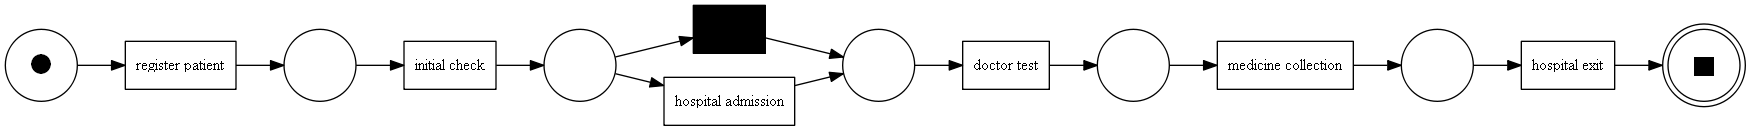

In [2]:
log = xes_importer.apply('../data/final20dayemergencysyntheticlog.xes')
net, initial_marking, final_marking = pnml_importer.apply("../data/petrinetdrift.pnml")    


gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [3]:
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
net 

places: [ n1, n2, n3, n4, n5, n6, n7 ]
transitions: [ (n10, None), (n11, 'hospital admission'), (n12, 'doctor test'), (n13, 'medicine collection'), (n14, 'hospital exit'), (n8, 'register patient'), (n9, 'initial check') ]
arcs: [ (n10, None)->n5, (n11, 'hospital admission')->n5, (n12, 'doctor test')->n6, (n13, 'medicine collection')->n7, (n14, 'hospital exit')->n2, (n8, 'register patient')->n3, (n9, 'initial check')->n4, n1->(n8, 'register patient'), n3->(n9, 'initial check'), n4->(n10, None), n4->(n11, 'hospital admission'), n5->(n12, 'doctor test'), n6->(n13, 'medicine collection'), n7->(n14, 'hospital exit') ]

# Generic methods

In [6]:
##usage= get_labels_set(input_transition_set)
def get_labels_set(input_transition_set):
    label_set=set()
    for transition in input_transition_set:
        label_set.add(transition._Transition__get_label())
    return label_set

##usage= get_input_transitions('n4')
def get_initial_start(intial_place):
    for place in net.places:
        if place._Place__get_name()==intial_place:
            initial_start=place
    return initial_start

##usage= get_input_transitions(net,initial_start)
def get_input_transitions(net,place):
    transition=list()
    if place in net.places:
        for arc in net.arcs:
            if arc._Arc__get_target()==place:
                if arc._Arc__get_source()._Transition__get_label() is None:
                    transition.append(arc._Arc__get_source())
                    for new_place in arc._Arc__get_source()._Transition__get_in_arcs():
                        transition.extend(get_input_transitions(net,new_place._Arc__get_source()))
                else:
                    transition.append(arc._Arc__get_source())
        return transition
    else:
        return None
    
##usage= get_output_transitions(net,initial_start)
def get_output_transitions(net,place):
    transition=list()
    if place in net.places:
        for arc in net.arcs:
            if arc._Arc__get_source()==place:
                transition.append(arc._Arc__get_target())
        return transition
    else:
        return None
    
def filter_none(input_transition_set):
    transition_set=set()
    for transition in input_transition_set:
        if transition._Transition__get_label() is not None:
            transition_set.add(transition)
    return transition_set

In [7]:
def createZone(replayed_traces,log,placeSet):
    input_transition_set=set()
    input_transition_label_set=set()
    output_transition_set=set()
    output_transition_label_set=set()
    all_transition_set=set()
    all_transition_label_set=set()
    for start in placeSet:
        print(start)
        initial_start=get_initial_start(start)
        input_transition_set|=set(get_input_transitions(net,initial_start))
        output_transition_set|=set(get_output_transitions(net,initial_start))
    
    all_transition_set|=input_transition_set
    all_transition_set|=output_transition_set
    temp=input_transition_set.difference(output_transition_set)
    output_transition_set.difference_update(input_transition_set)
    input_transition_set=temp

    input_transition_set=filter_none(input_transition_set)
    all_transition_set.difference_update(input_transition_set)
    all_transition_set=filter_none(all_transition_set)
    
    input_transition_label_set|=get_labels_set(input_transition_set)    
    output_transition_label_set|=get_labels_set(output_transition_set)
    all_transition_label_set|=get_labels_set(all_transition_set)
    
    print(all_transition_set)
    print(all_transition_label_set)
    print(input_transition_set)
    print(input_transition_label_set)
    print(output_transition_set)
    print(output_transition_label_set)

    token_produced=0
    token_consumed=0
    token_left=0
    dataframe=pd.DataFrame(columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
    for trace,case in zip(replayed_traces, log):
        last_event=None
        first_event=None
        goodstart=False
        if trace['trace_is_fit']==True or True:
            backupstart=None
            backup_event=None
            for active_trace in trace['activated_transitions']:
                if active_trace in input_transition_set :
                    goodstart=True
                    for events in case:
                        if events['concept:name'] in input_transition_label_set:
                            last_event=events
                            backup_event=events
                if active_trace in output_transition_set:
                    for events in case:
                        if events['concept:name'] in output_transition_label_set:
                            first_event=events
                if active_trace in all_transition_set :
                    for events in case:
                        if events['concept:name'] in all_transition_label_set:
                            backup_event=events
                            if goodstart==False and backupstart is None:
                                backupstart=events
                            
            if first_event is None and backup_event is not None:
                first_event=backup_event
            if last_event is None and backupstart is not None:
                last_event=backupstart
            if last_event is not None and first_event  is not None :
                token_produced=token_produced+1
                token_consumed=token_consumed+1
                row_df = pd.DataFrame([[last_event['concept:name'], last_event['time:timestamp'],first_event['concept:name'], first_event['time:timestamp'], case.attributes['concept:name']]],columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
                dataframe = pd.concat([row_df, dataframe], ignore_index=True)
    
    print(token_produced)
    print(token_consumed)
    return dataframe

# Create Zones

In [8]:
RegistrationZone=createZone(replayed_traces,log ,['n3'])
AdmissionZone=createZone(replayed_traces,log ,['n4','n5'])
DoctorZone=createZone(replayed_traces,log ,['n6'])
MedicineZone=createZone(replayed_traces,log ,['n7'])

n3
{(n9, 'initial check')}
{'initial check'}
{(n8, 'register patient')}
{'register patient'}
{(n9, 'initial check')}
{'initial check'}
2710
2710
n4
n5
{(n11, 'hospital admission'), (n12, 'doctor test')}
{'hospital admission', 'doctor test'}
{(n9, 'initial check')}
{'initial check'}
{(n12, 'doctor test')}
{'doctor test'}
2710
2710
n6
{(n13, 'medicine collection')}
{'medicine collection'}
{(n12, 'doctor test')}
{'doctor test'}
{(n13, 'medicine collection')}
{'medicine collection'}
2710
2710
n7
{(n14, 'hospital exit')}
{'hospital exit'}
{(n13, 'medicine collection')}
{'medicine collection'}
{(n14, 'hospital exit')}
{'hospital exit'}
2710
2710


In [9]:
def globaldata(Zone):
    Zone['StartDateTime'] = pd.to_datetime(Zone['StartTime'], utc=True)
    Zone['StartDate'] = pd.to_datetime(Zone['StartDateTime']).dt.date
    Zone['EndDateTime'] = pd.to_datetime(Zone['EndTime'], utc=True)
    Zone['EndDate'] = pd.to_datetime(Zone['EndDateTime']).dt.date
    Zone['TotalWaitingTime']=  (pd.to_datetime(Zone['EndTime'], utc=True)-pd.to_datetime(Zone['StartTime'], utc=True))

    global minstartdate
    global maxenddate
    if minstartdate is None:
        minstartdate=min(Zone['StartDate'])
    else :
        minstartdate=min(minstartdate,min(Zone['StartDate']))
    if maxenddate is None:
        maxenddate=max(Zone['EndDate'])
    else :
        maxenddate=max(maxenddate,max(Zone['EndDate']))


In [10]:
def DataPreparation(Zone,timeFrame):
    global minstartdate
    global maxenddate
    print(minstartdate)
    print(maxenddate)
    return pd.DataFrame({'date':pd.date_range(start=minstartdate, end=maxenddate, freq=timeFrame),
                                       'tokenproduced':0,'tokenconsumed':0,'tokenleft':0,'oneframetoken':0,
                                       'TimeSpent':0,'Count':0})

def getZoneData(Zone,timeFrame):
    ZoneDataFrame=DataPreparation(Zone,timeFrame)
    if timeFrame=='H':
        timeformat='%Y-%m-%d %H'
    if timeFrame=='D':
        timeformat='%Y-%m-%d'
    if timeFrame=='W':
        timeformat='%Y-%m-%W'
    if timeFrame=='M':
        timeformat='%Y-%m'
    for index, row in ZoneDataFrame.iterrows():
        currentdate=row['date'].strftime(timeformat)
        print(currentdate)
        currentDateValue=row['date']
        produced=0
        left=0
        consumed=0
        oneFrame=0
        waiting=td(days=0)
        waitingdays=0
        #print(type(waiting))
        count=0
        itemlist=[]
        #if currentdate.strftime('%Y-%m-%d')<='1999-10-13':
        #    continue
        #print(currentdate)
        for indexdata, rowdata in Zone.iterrows():
            oneFramecheck=False
            StartDate=rowdata['StartTime'].strftime(timeformat)
            EndDate=rowdata['EndTime'].strftime(timeformat)
            #print(StartDate)
            #TotalWaitingTime=rowdata['TotalWaitingTime']
            TotalWaitingTime=rowdata['TotalWaitingTime']
            if timeFrame=='H':
                WaitingTimeTillDate=currentDateValue+td(hours=1)
            if timeFrame=='D':
                WaitingTimeTillDate=currentDateValue+td(hours=24)
            if timeFrame=='W':
                WaitingTimeTillDate=currentDateValue+td(weeks=1)
            if timeFrame=='M':
                WaitingTimeTillDate=currentDateValue+td(weeks=4)

            if currentdate==StartDate and currentdate==EndDate:
                oneFrame=oneFrame+1
                oneFramecheck=True
            if currentdate==StartDate:
                produced=produced+1
            if currentdate==EndDate:
                consumed=consumed+1
                WaitingTimeTillDate=rowdata['EndDateTime']
                itemlist.append(StartDate)
            if currentdate<EndDate and currentdate>=StartDate:
                #print(StartDate+" "+currentdate+" "+EndDate)
                left=left+1
            if currentdate<=EndDate and currentdate>=StartDate:
                TotalWaitingTime=WaitingTimeTillDate.replace(tzinfo=None)-rowdata['StartDateTime'].replace(tzinfo=None)
                if waiting is None:
                    waiting=TotalWaitingTime
                else:
                    if waiting.days<100000:
                        waiting=waiting+TotalWaitingTime
                        waitingdays=waiting.days
                    else :
                        waitingdays=TotalWaitingTime.days+waitingdays
                count=count+1
        ZoneDataFrame.at[index, 'tokenproduced']=produced
        ZoneDataFrame.at[index, 'tokenconsumed']=consumed
        ZoneDataFrame.at[index, 'oneframetoken']=oneFrame
        ZoneDataFrame.at[index, 'tokenleft']=left
        if waiting.days<100000:
            ZoneDataFrame.at[index, 'TimeSpent']=waiting
        else:
            ZoneDataFrame.at[index, 'TimeSpent']=waitingdays
        ZoneDataFrame.at[index, 'Count']=count
    return ZoneDataFrame.copy()

In [11]:
minstartdate=None
maxenddate=None
timeFrame='M'
timeFrame='H'
for zone in [RegistrationZone, AdmissionZone, DoctorZone,MedicineZone]:
    globaldata(zone)
print(minstartdate)
print(maxenddate)
if timeFrame=='H':
    maxenddate=maxenddate+td(hours=1)
if timeFrame=='D':
    maxenddate=maxenddate+td(days=1)
if timeFrame=='W':
    maxenddate=maxenddate+td(days=7)
if timeFrame=='M':
    maxenddate=maxenddate+td(days=31)

2020-01-22
2020-02-19


# create process log for each zone and save them for reuse

In [ ]:
RegistrationZoneDF=getZoneData(RegistrationZone,timeFrame)
RegistrationZoneDF.to_csv(r'C:\Users\bittu\RWTH\Thesis\Daily20FinalRegistrationZoneDFHospital.csv', index = False, header=True)

AdmissionZoneDF=getZoneData(AdmissionZone,timeFrame)
AdmissionZoneDF.to_csv(r'C:\Users\bittu\RWTH\Thesis\Daily20FinalAdmissionZoneDFHospital.csv', index = False, header=True)

DoctorZoneDF=getZoneData(DoctorZone,timeFrame)
DoctorZoneDF.to_csv(r'C:\Users\bittu\RWTH\Thesis\Daily20FinalDoctorZoneDFHospital.csv', index = False, header=True)

MedicineZoneDF=getZoneData(MedicineZone,timeFrame)
MedicineZoneDF.to_csv(r'C:\Users\bittu\RWTH\Thesis\Daily20FinalMedicineZoneDFHospital.csv', index = False, header=True)


# Start from here in case process logs already exists

In [12]:
RegistrationZoneDF= pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\Daily20FinalRegistrationZoneDFHospital.csv')
AdmissionZoneDF = pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\Daily20FinalAdmissionZoneDFHospital.csv')
DoctorZoneDF= pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\Daily20FinalDoctorZoneDFHospital.csv')
MedicineZoneDF=pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\Daily20FinalMedicineZoneDFHospital.csv')

RegistrationZoneDF['TimeSpent']=pd.to_timedelta(RegistrationZoneDF['TimeSpent'])
AdmissionZoneDF['TimeSpent']=pd.to_timedelta(AdmissionZoneDF['TimeSpent'])
DoctorZoneDF['TimeSpent']=pd.to_timedelta(DoctorZoneDF['TimeSpent'])
MedicineZoneDF['TimeSpent']=pd.to_timedelta(MedicineZoneDF['TimeSpent'])

RegistrationZoneDF['date']=pd.to_datetime(RegistrationZoneDF['date'])
AdmissionZoneDF['date']=pd.to_datetime(AdmissionZoneDF['date'])
DoctorZoneDF['date']=pd.to_datetime(DoctorZoneDF['date'])
MedicineZoneDF['date']=pd.to_datetime(MedicineZoneDF['date'])


# Plots and Analysis

[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Number of patients'),
 Text(0.5, 1.0, 'Number of patients arriving in the hospital')]

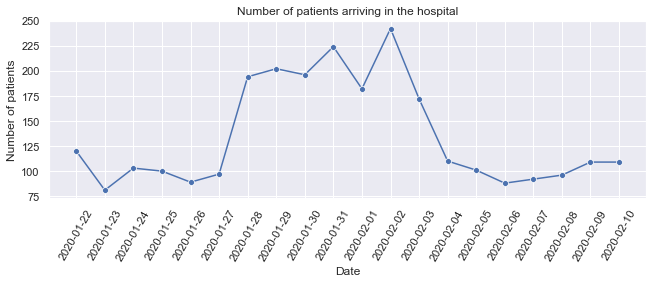

In [13]:
sns.set(rc={'figure.figsize':(10.7,3.27)})
gfg=sns.lineplot(data=newdf[0:20],x='datenew',y='tokenproduced',marker='o')

gfg.set(xticks=newdf[0:20].datenew.values)
plt.xticks(rotation=60)
gfg.set(xlabel ="Date", ylabel = "Number of patients", title ='Number of patients arriving in the hospital')

# More generic methods for Processing and training

In [14]:
def process(Zone):
    def categorise(row):  
        if type( row['TimeSpent']) is int :
            return row['TimeSpent']
        return row['TimeSpent'].days
    Zone['DaysSpent'] = Zone.apply(lambda row: categorise(row), axis=1)

    def categorise(row):   
        if row['Count']==0:
            return 0
        return row['DaysSpent']/row['Count']
    Zone['AverageTimeSpent'] = Zone.apply(lambda row: categorise(row), axis=1)
    index=Zone.index.values
    try:
        Zone.insert(0, column='index',value = index+1)
    except:
        print("index already exists")

def AnalyzeZone(Zone,featurelist,penalty,target=False):
    global timeFrame
    global timeFrameValue
    #reduced=pca_reduction(Zone[featurelist],len(featurelist), normalize = True, normalize_function="max")
    Zone['drift'] = 0
    for feature in featurelist:
        
        algo_python = rpt.Pelt(model="rbf",min_size=1,jump=1).fit(Zone[[feature]])  # written in pure python
        result = algo_python.predict(penalty)
        Zone.loc[Zone['index'].isin(result),'drift']=1
        
        
        fig, ax_array = rpt.display(Zone[feature], result)
        #fig.suptitle('Change in Behavior of '+feature+' over '+ timeFrameValue, fontsize=12)
        fig.suptitle('Change in Behavior of token produced in Registration Zone over '+ timeFrameValue, fontsize=12)
        plt.ylabel('Number of token produced')
        plt.xlabel(timeFrameValue)
        Zone['chunkmean'] = 0
        Zone['chunkindex'] = 1
        Zone['chunkstd']=0
        start=0
        sns.set(rc={'figure.figsize':(11.7,3.27)})
        i=1
        for index in result:
            Zone['chunkmean'].iloc[start:index]=Zone[ [feature] ].iloc[start:index].mean(axis=0)[0]
            Zone['chunkstd'].iloc[start:index]=Zone[ [feature] ].iloc[start:index].std(axis=0)[0]
            Zone['chunkindex'].iloc[start:index]=i
            i=i+1
            start=index
        Zone['pthreshold'] = Zone['chunkmean']+(Zone['chunkstd'])
        Zone['nthreshold'] = Zone['chunkmean']-(Zone['chunkstd'])
        
        if target==True:
            Zone['Strange_'+feature]=0
            def categorise(row,feature):
                if row['pthreshold'] < row[feature] or row['nthreshold']>row[feature] :
                    return 1
                return 0
            Zone['Strange_'+feature] = Zone.apply(lambda row: categorise(row,feature), axis=1)
        
        f, ax = plt.subplots()
        result=result[:-1]
        print(Zone.name,feature,result)
        
        plt.vlines(result,min(Zone[feature]),max(Zone[feature]) , linestyles ="dashed", colors ="gray",label='Changepoints')

        sns.lineplot(data=Zone, x='index', y=feature, color='b',label=feature).set(title=feature+', baseline and threshold over timeframe('+timeFrameValue+') superimposed with Changepoints')
        sns.lineplot(data=Zone, x='index', y='chunkmean',color='orange', label="Baseline")
        sns.lineplot(data=Zone, x='index', y='pthreshold',color='g',label="Threshold")
        sns.lineplot(data=Zone, x='index', y='nthreshold',color='g')
        plt.xlabel(timeFrameValue)
        plt.legend()
        
def max_lag(x,y):
    corr = np.correlate(x, y, mode='full')
    # find lag with highest correlation
    lag = np.argmax(corr) - len(x) + 1
    # create lagged variable
    lagged_y = y.shift(lag)
    # calculate correlation between x and lagged_y
    corr = x.corr(lagged_y)
    return lag,corr

sns.set(rc={'figure.figsize':(30.7,11.27)})
def traindtmultiple(x,y,columnlist,feature,i):
    ros = RandomOverSampler(random_state=0)
    
    try: 
        X_resampled, y_resampled = ros.fit_resample(x, y)
        x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3)
    except: 
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    
    
    #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    clf = tree.DecisionTreeClassifier(criterion="entropy",max_depth=4,min_samples_leaf=15)
    clf = clf.fit(x_train, y_train)
    prediction=clf.predict(x_test)
    Y_test_pred = pd.DataFrame(prediction).applymap(lambda x: 1 if x>0.5 else 0)
    #Y_test_pred = pd.DataFrame(prediction)
    if accuracy_score(y_test, Y_test_pred)>0.8 and accuracy_score(y_test, Y_test_pred)<1 and f1_score(y_test, Y_test_pred, average="macro")>0.7:
        print('feature-',feature,':',' Day :',i)
        print("Mean absolute error LR-",metrics.mean_absolute_error(y_test, Y_test_pred))
        metrics.mean_squared_error(y_test, Y_test_pred)
        print("Mean Squared error LR-",np.sqrt(metrics.mean_squared_error(y_test, Y_test_pred)))
        print("Accuracy:",accuracy_score(y_test, Y_test_pred))
        print("F1:",f1_score(y_test, Y_test_pred, average="macro"))
        print("Precision:",precision_score(y_test, Y_test_pred, average="macro"))
        print("Recall:",recall_score(y_test, Y_test_pred, average="macro"))
        tree.plot_tree(clf,feature_names=columnlist,fontsize=16)
        cm = confusion_matrix(y_test, Y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()



def predict(targetZone,predictorZone,featurelist,predictionDelay):
    for feature in featurelist:
        combineddata=None
        for i in range(len(predictorZone)):
            if combineddata is None:
                combineddata=pd.merge(predictorZone[0],predictorZone[1],on=['date'],how='left',suffixes=("_"+predictorZone[0].name, "_"+predictorZone[1].name))
                combineddata['tokenproduced']=0
                combineddata['tokenconsumed']=0
                combineddata['tokenleft']=0
                combineddata['Count']=0
                combineddata['oneframetoken']=0
                combineddata['AverageTimeSpent']=0
            elif i>1:
                combineddata=combineddata.merge(predictorZone[i],on=['date'],how='left',suffixes=(None,"_"+predictorZone[i].name))
            
        def categorise(row,numdays):   
            return row['date'] -  datetime.timedelta(hours=1)
        for j in range (predictionDelay):
            combineddata=combineddata.merge(targetZone[['date',feature]].rename({feature: feature+'_'+str(j)}, axis=1), on='date', how='left')
            targetZone['date'] = targetZone.apply(lambda row: categorise(row,j), axis=1)
        combineddata=combineddata.dropna()
        for j in range (predictionDelay):
            combineddata[feature+'_'+str(j)] = combineddata[feature+'_'+str(j)].astype(int)
        
        columnlist=[]
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('token')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('oneframetoken')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('AverageTimeSpent')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('Count')].columns)
        x = combineddata[columnlist]
        columnlistnew = [s.replace('token', 'token ') for s in columnlist]
        columnlistnew = [s.replace('oneframetoken', 'one frame token') for s in columnlistnew]
        columnlistnew = [s.replace('AverageTimeSpent', 'Time Spent') for s in columnlistnew]
        
        for i in range(predictionDelay):
            
            y = combineddata[feature+'_'+str(i)].fillna(0).copy()
            x = combineddata[columnlist].copy()
            traindtmultiple(x,y,columnlistnew,feature,i)


# Task 1- Analysis of Zones

Registration Zone tokenproduced [145, 301, 481]
Registration Zone tokenconsumed [148, 319, 482]
Registration Zone tokenleft [146, 156, 206, 262, 282, 314, 481]
Registration Zone oneframetoken []
Registration Zone Count [147, 155, 206, 265, 282, 314, 481]
Registration Zone AverageTimeSpent []
Test Zone tokenproduced [148, 319, 482]
Test Zone tokenconsumed [8, 150, 153, 324, 487]
Test Zone tokenleft [5, 49, 76, 116, 152, 161, 241, 288, 306, 394, 433, 485, 516, 552, 590, 629]
Test Zone oneframetoken []
Test Zone Count [6, 50, 76, 116, 152, 161, 243, 268, 288, 307, 394, 434, 486, 517, 553, 591, 630]
Test Zone AverageTimeSpent [58, 101, 167, 253, 301, 416, 455, 486, 529, 575, 614, 650]
Doctor Zone tokenproduced [8, 150, 153, 324, 487]
Doctor Zone tokenconsumed [13, 155, 158, 329, 492]
Doctor Zone tokenleft [9, 32, 157, 235, 250, 257, 274, 292, 306, 311, 328, 489]
Doctor Zone oneframetoken []
Doctor Zone Count [10, 32, 158, 274, 293, 306, 312, 329, 490]
Doctor Zone AverageTimeSpent [10, 161,

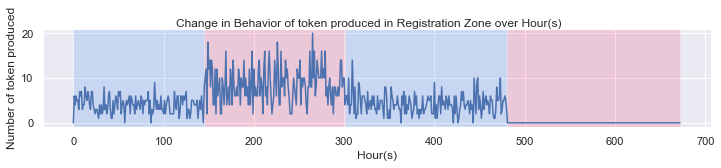

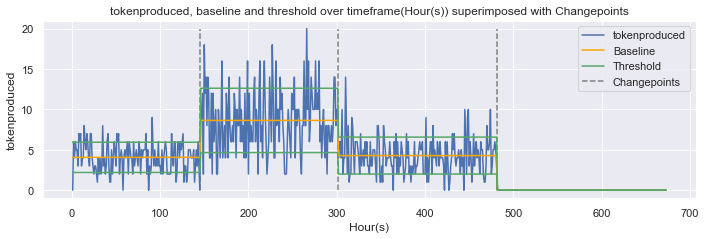

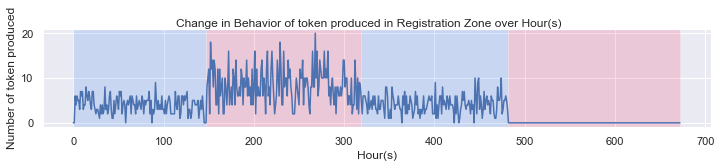

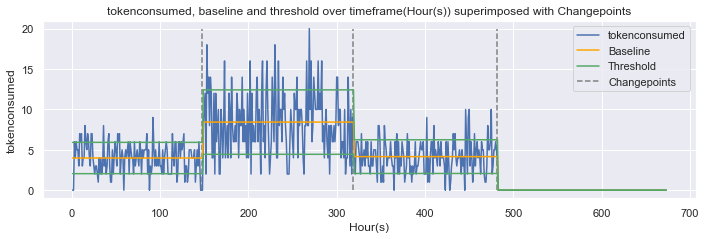

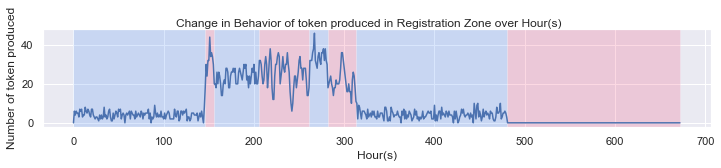

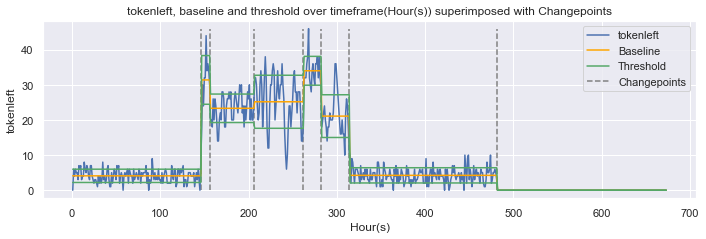

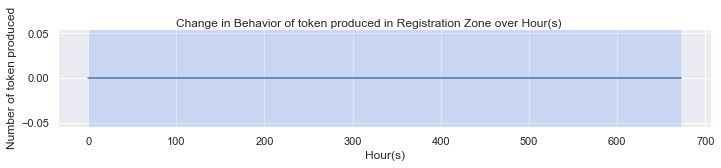

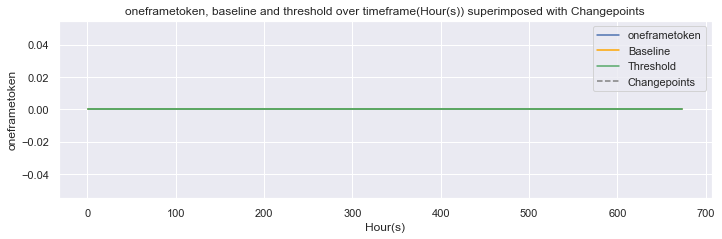

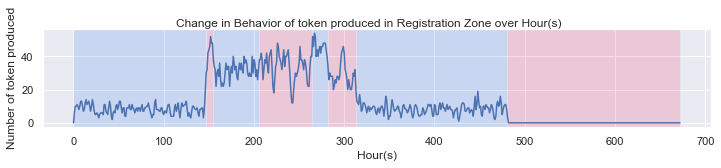

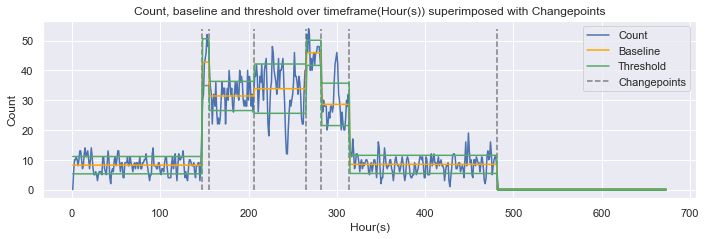

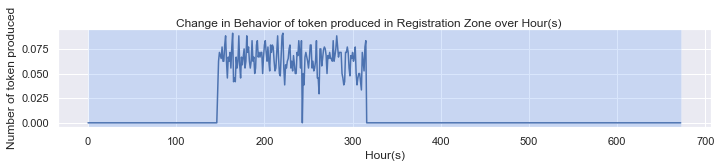

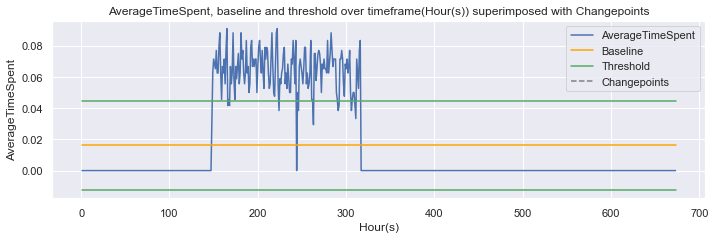

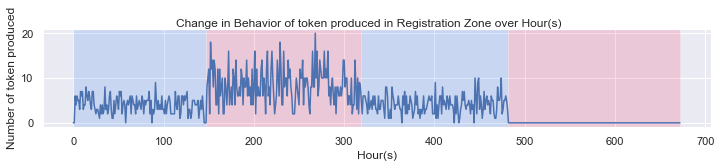

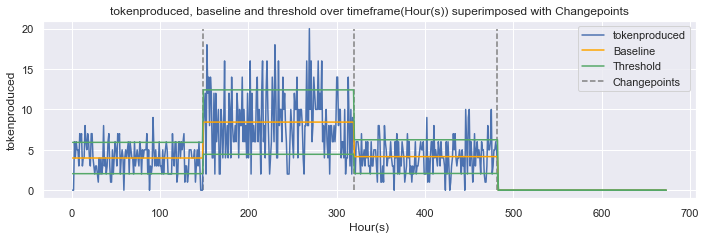

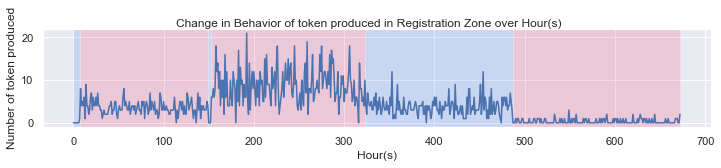

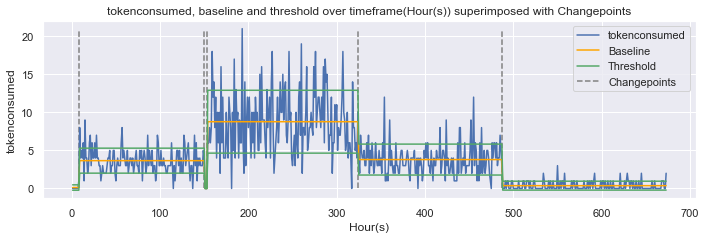

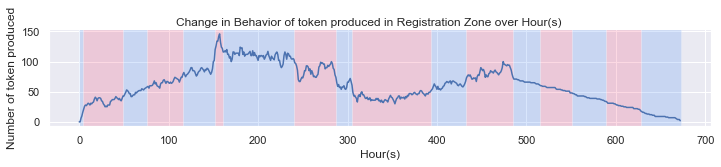

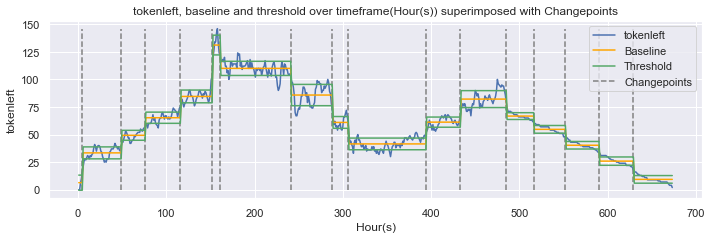

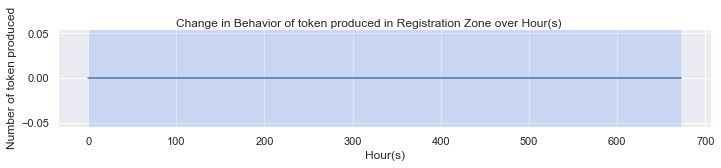

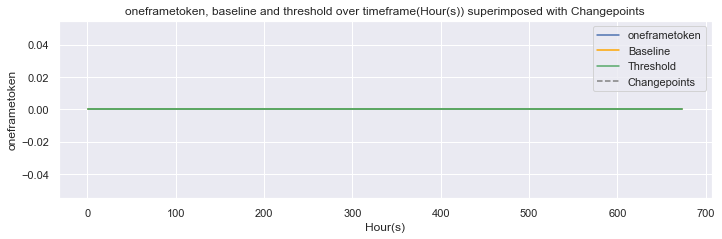

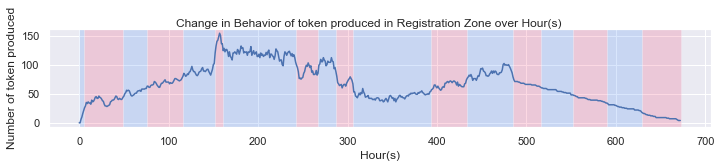

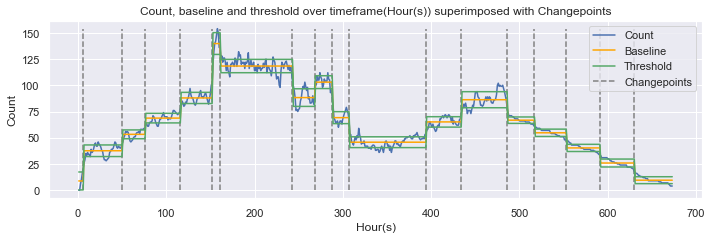

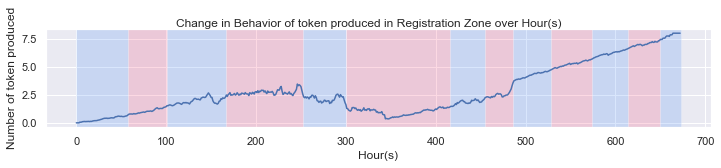

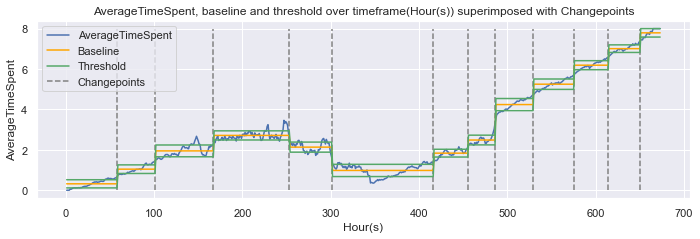

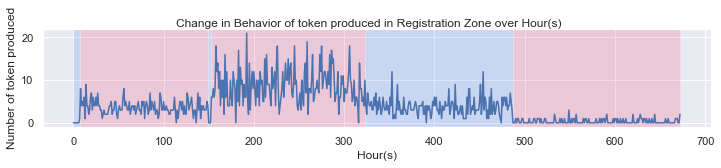

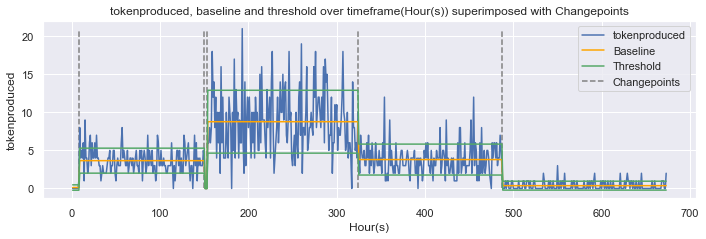

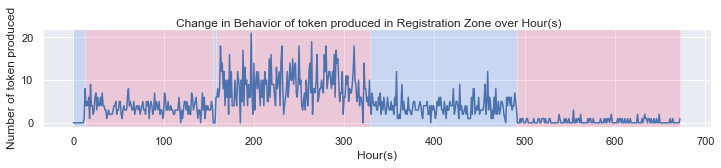

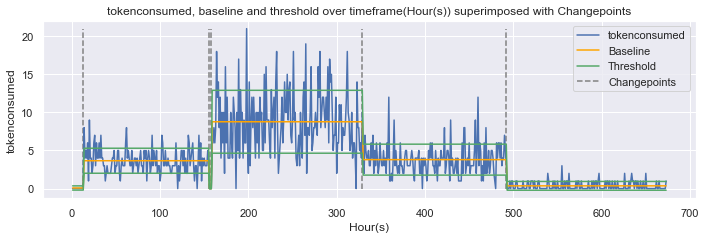

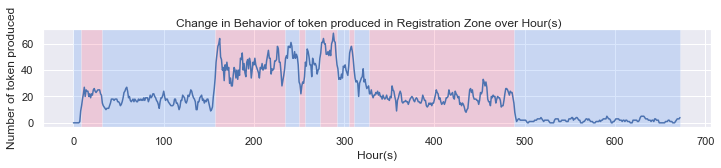

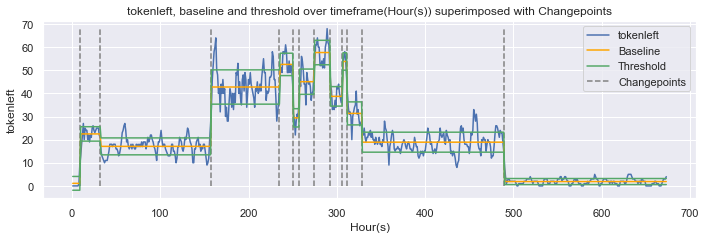

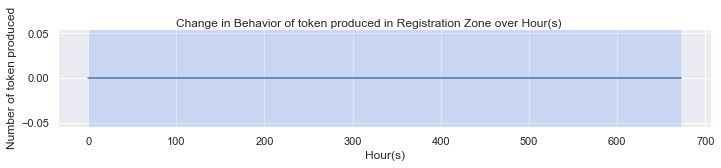

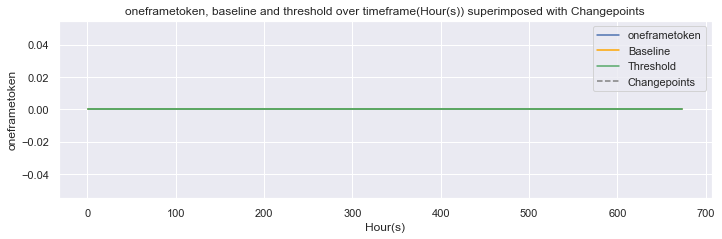

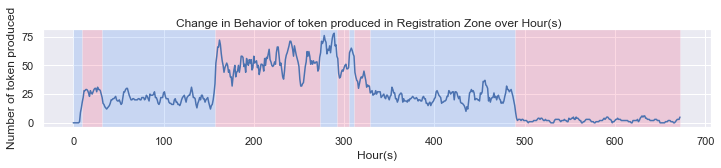

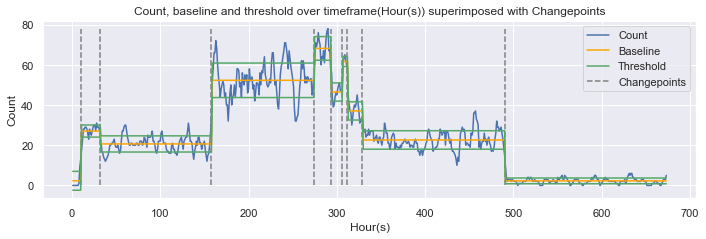

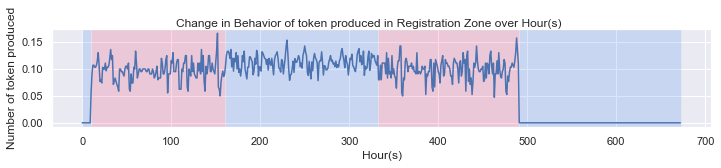

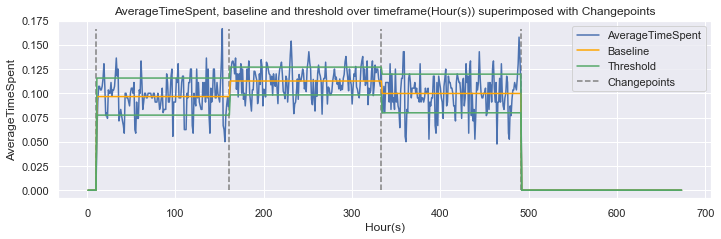

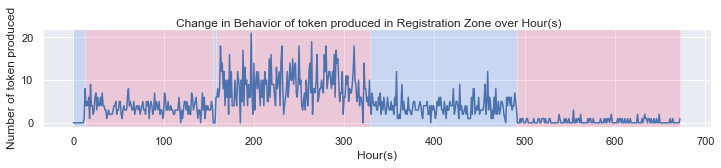

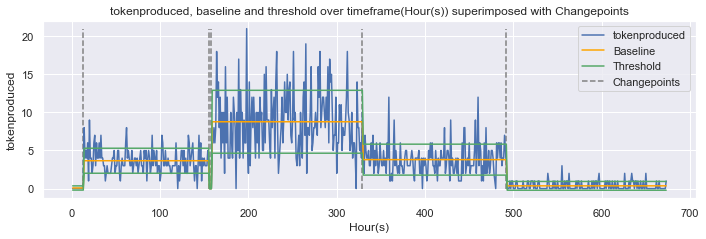

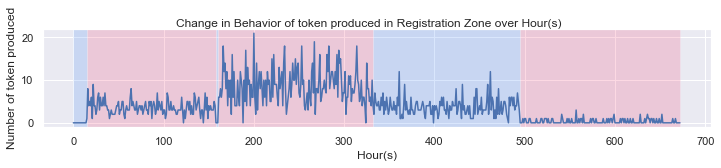

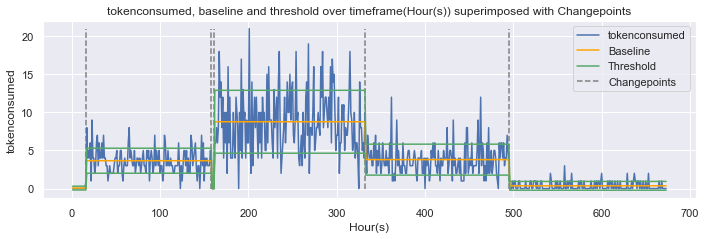

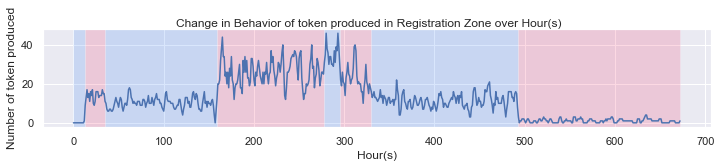

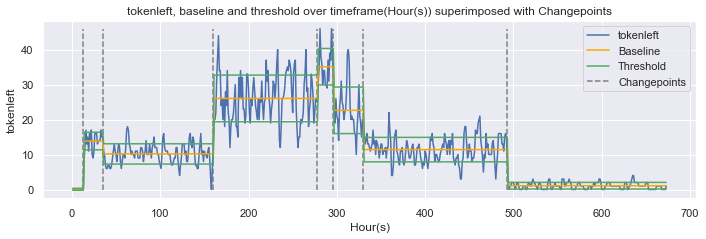

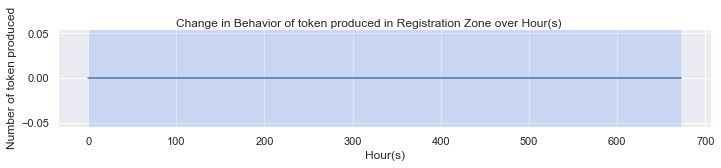

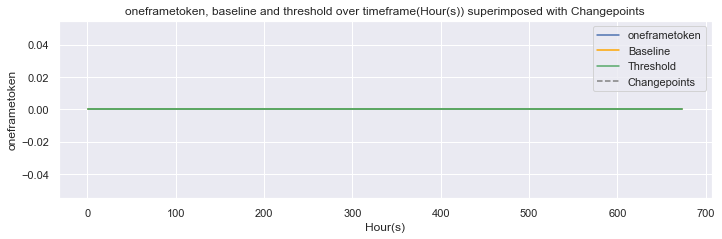

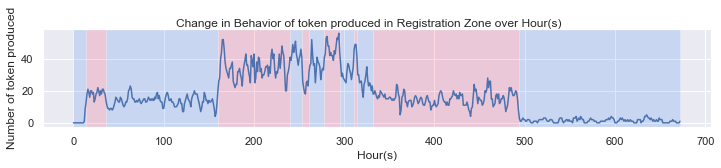

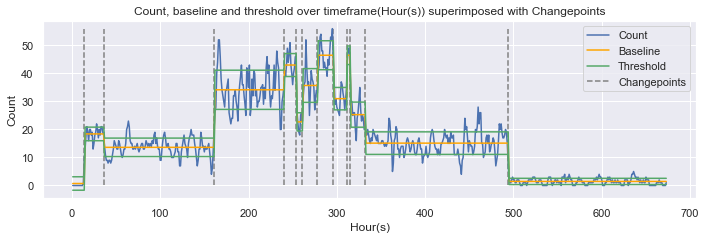

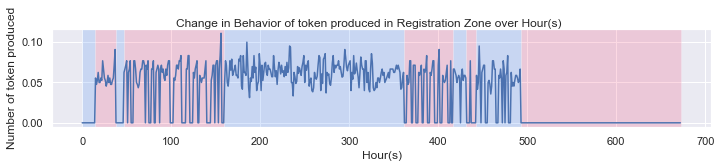

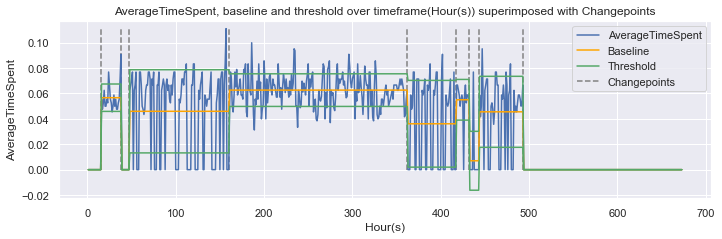

In [16]:
import warnings
warnings.filterwarnings('ignore')
timeFrame='H'
if timeFrame=='H':
    timeFrameValue='Hour(s)'
if timeFrame=='D':
    timeFrameValue='Day(s)'
if timeFrame=='W':
    timeFrameValue='Week(s)'
if timeFrame=='M':
    timeFrameValue='Month(s)'

RegistrationZoneDF.name = 'Registration Zone'
AdmissionZoneDF.name = 'Test Zone'
DoctorZoneDF.name = 'Doctor Zone'
MedicineZoneDF.name = 'Medicine Zone'

zonelist=[]  
featurelist=['tokenproduced', 'tokenconsumed', 'tokenleft','oneframetoken', 'Count', 'AverageTimeSpent']
targetzonelist=[RegistrationZoneDF, AdmissionZoneDF, DoctorZoneDF, MedicineZoneDF]

pen=3

for zone in  targetzonelist:
    process(zone)

for zone in targetzonelist:
    AnalyzeZone(zone,featurelist,pen,True)

zonelist=[]
for zone in targetzonelist:
    newzone=zone.iloc[:, :-6].copy()
    newzone.name=zone.name
    zonelist.append(newzone)  

# Task 2 Analysis of interconnection

In [19]:
RegistrationZoneDF.name = 'Registration Zone'
AdmissionZoneDF.name = 'Test Zone'
DoctorZoneDF.name = 'Doctor Zone'
MedicineZoneDF.name = 'Medicine Zone'

zonelist=[]  
featurelist=['tokenproduced', 'tokenconsumed', 'tokenleft','oneframetoken', 'Count']
targetzonelist=[RegistrationZoneDF, AdmissionZoneDF, DoctorZoneDF, MedicineZoneDF]

Corrdataframe=pd.DataFrame(columns= ['targetZone','targetFeature','sourceZone','sourceFeature','lag','MaxCorr'])     


for targetZone in targetzonelist:
    for targetFeature in featurelist:
        for zone in targetzonelist:
            lagsum=0
            for feature in featurelist:
                maxlag,maxcorr = max_lag(targetZone[targetFeature].dropna(),zone[feature].dropna())
                corrow_df = pd.DataFrame([[targetZone.name, targetFeature,zone.name, feature, maxlag,maxcorr]],columns=  ['targetZone','targetFeature','sourceZone','sourceFeature','lag','MaxCorr'])
                Corrdataframe = pd.concat([corrow_df, Corrdataframe], ignore_index=True)
Data=Corrdataframe[Corrdataframe['MaxCorr']>0.7].sort_values(by='MaxCorr')

In [21]:
Data[(Data['targetFeature']!=Data['sourceFeature']) & (Data['lag']>0)].sort_values(by=['MaxCorr'], ascending=False)

targetZone  targetFeature         sourceZone  sourceFeature lag  \
169    Doctor Zone  tokenconsumed        Doctor Zone  tokenproduced   5   
69   Medicine Zone  tokenconsumed        Doctor Zone  tokenproduced   8   
93   Medicine Zone  tokenproduced          Test Zone  tokenconsumed   5   
64   Medicine Zone  tokenconsumed      Medicine Zone  tokenproduced   3   
212      Test Zone          Count          Test Zone      tokenleft   1   
..             ...            ...                ...            ...  ..   
79   Medicine Zone  tokenconsumed  Registration Zone  tokenproduced  17   
50   Medicine Zone      tokenleft          Test Zone          Count   9   
255      Test Zone      tokenleft  Registration Zone          Count   3   
112    Doctor Zone          Count          Test Zone      tokenleft   6   
12   Medicine Zone          Count          Test Zone      tokenleft  10   

      MaxCorr  
169  1.000000  
69   1.000000  
93   1.000000  
64   1.000000  
212  0.994662  
..        ...  
79   0.728238  
50   0.725962  
255  0.719214  
112  0.715990  
12   0.702299  

[69 rows x 6 columns]

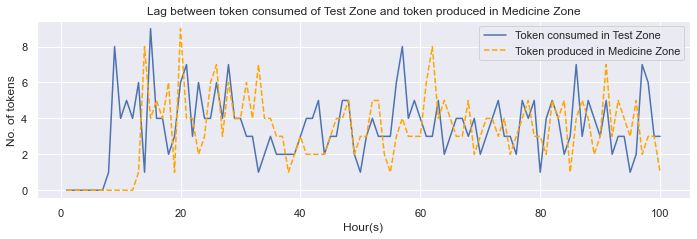

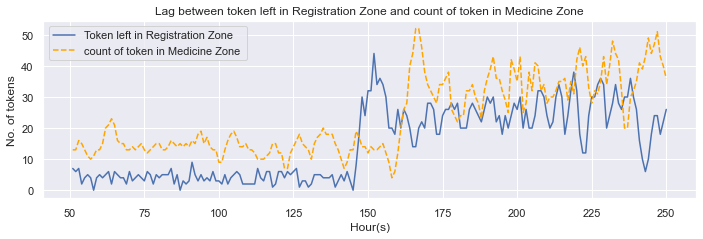

In [17]:
sns.lineplot(data=AdmissionZoneDF[:100], x='index', y='tokenconsumed', color='b',label='Token consumed in Test Zone').set(title='Lag between token consumed of Test Zone and token produced in Medicine Zone')
sns.lineplot(data=MedicineZoneDF[:100], x='index', y='tokenproduced',linestyle='--',color='orange', label="Token produced in Medicine Zone")
plt.xlabel(timeFrameValue)
plt.ylabel('No. of tokens')
plt.show()
sns.lineplot(data=RegistrationZoneDF[50:250], x='index', y='tokenleft', color='b',label='Token left in Registration Zone').set(title='Lag between token left in Registration Zone and count of token in Medicine Zone')
sns.lineplot(data=MedicineZoneDF[50:250], x='index', y='Count',color='orange', linestyle='--', label="count of token in Medicine Zone ")
plt.xlabel(timeFrameValue)
plt.ylabel('No. of tokens')
plt.show()

Text(0, 0.5, 'No. of tokens')

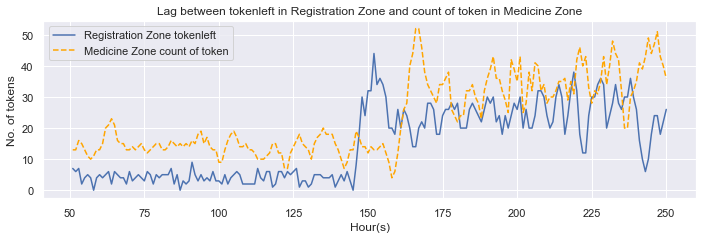

In [18]:
sns.lineplot(data=RegistrationZoneDF[50:250], x='index', y='tokenleft', color='b',label='Registration Zone tokenleft').set(title='Lag between tokenleft in Registration Zone and count of token in Medicine Zone')
sns.lineplot(data=MedicineZoneDF[50:250], x='index', y='Count',color='orange', linestyle='--', label="Medicine Zone count of token")
plt.xlabel(timeFrameValue)
plt.ylabel('No. of tokens')
   

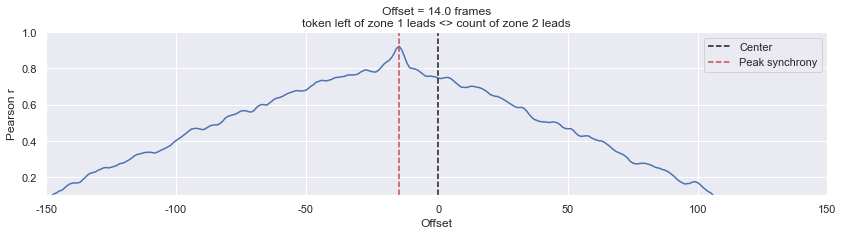

In [22]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = RegistrationZoneDF['tokenleft']
d2 = MedicineZoneDF['Count']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\ntoken left of zone 1 leads <> count of zone 2 leads',ylim=[.1,1],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()

# Task 3- Prediction

Medicine Zone
feature- Strange_tokenproduced :  Day : 0
Mean absolute error LR- 0.07169811320754717
Mean Squared error LR- 0.26776503357897047
Accuracy: 0.9283018867924528
F1: 0.9276049979151391
Precision: 0.935515873015873
Recall: 0.9258244893301382


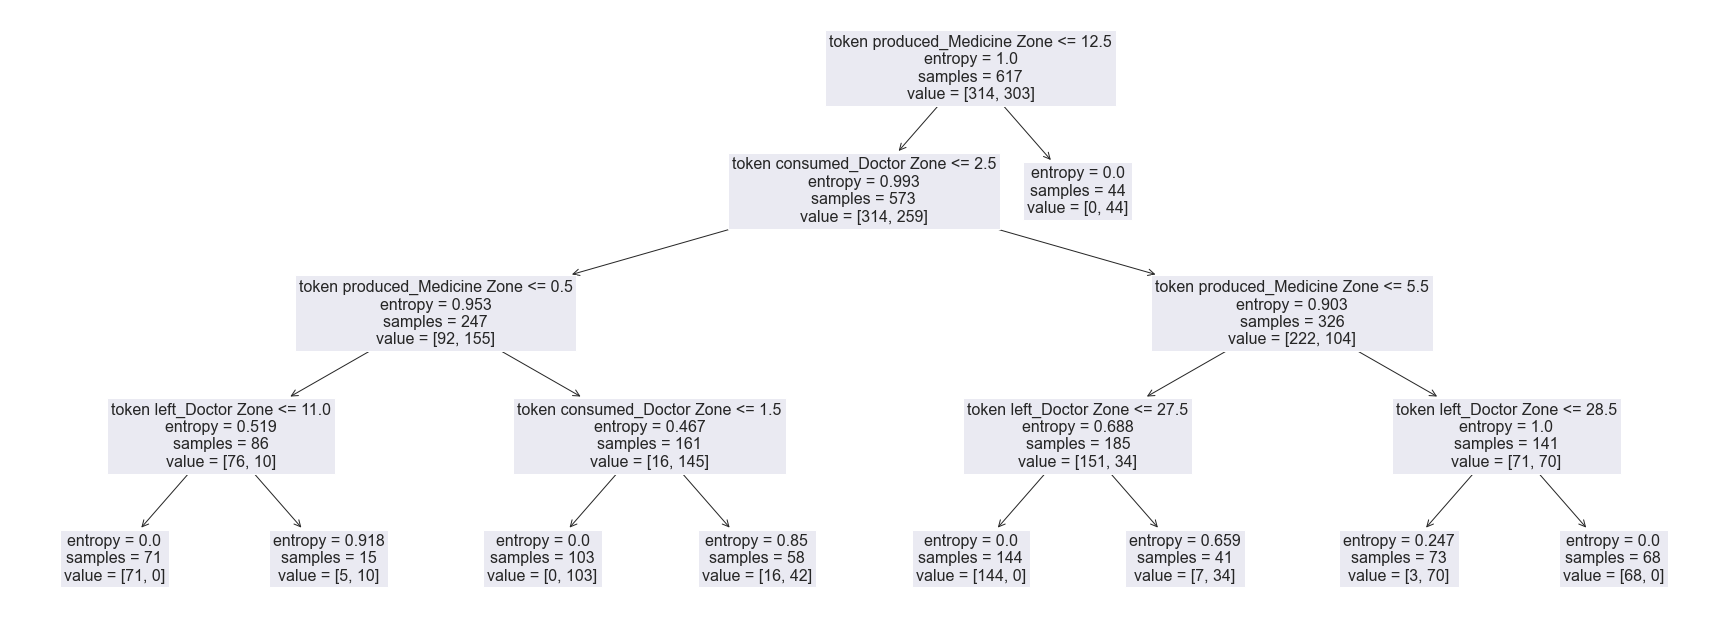

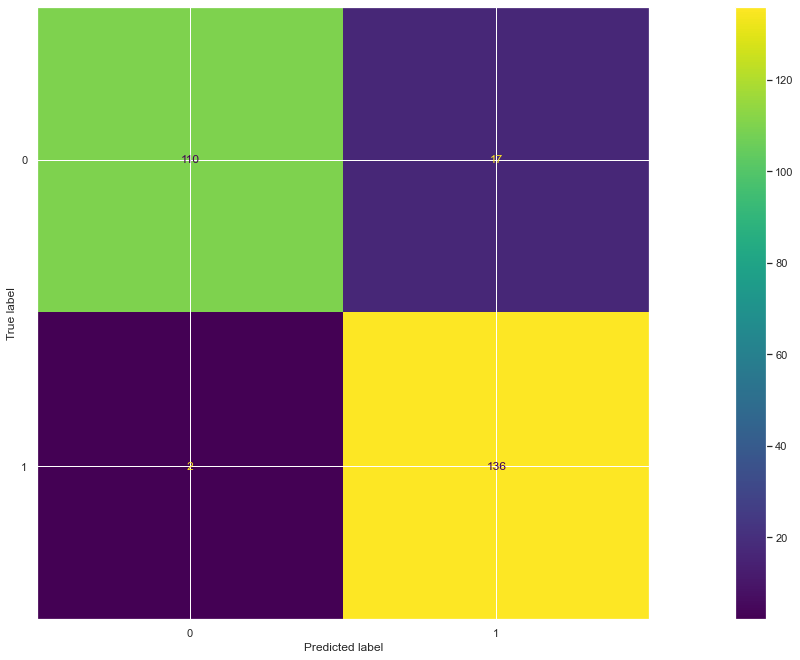

feature- Strange_tokenproduced :  Day : 5
Mean absolute error LR- 0.07604562737642585
Mean Squared error LR- 0.27576371656986687
Accuracy: 0.9239543726235742
F1: 0.923900462962963
Precision: 0.9277441508555465
Recall: 0.9253182870370371


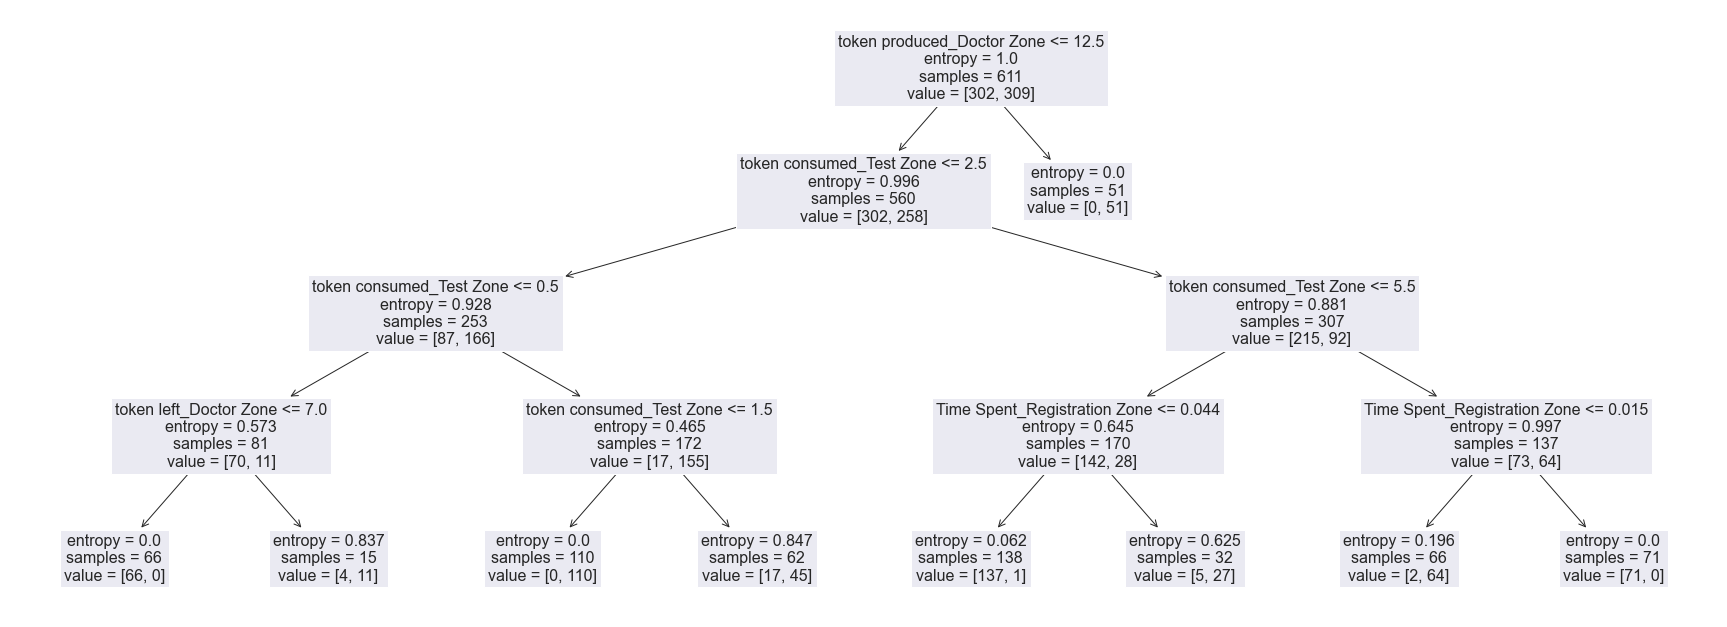

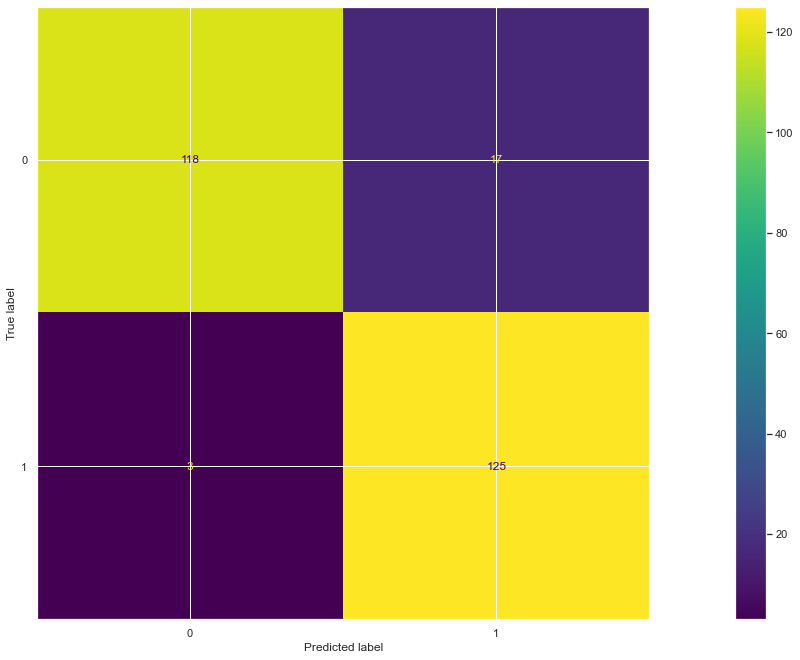

In [38]:
predictionDelay=40
targetfeaturelist=['Strange_tokenproduced', 'Strange_tokenconsumed', 'Strange_tokenleft','Strange_oneframetoken', 
             'Strange_Count', 'Strange_AverageTimeSpent']
targetzonelist=[MedicineZoneDF]
for targetZone in targetzonelist:
    print(targetZone.name)
    predict(targetZone.copy(),zonelist,targetfeaturelist,predictionDelay)

# Appendix( Additional test and analysis)

Registration Zone
feature- Strange_AverageTimeSpent :  Day : 23
Mean absolute error LR- 0.09523809523809523
Mean Squared error LR- 0.3086066999241838
Accuracy: 0.9047619047619048
F1: 0.9037050623624358
Precision: 0.9206349206349207
Recall: 0.9038461538461539


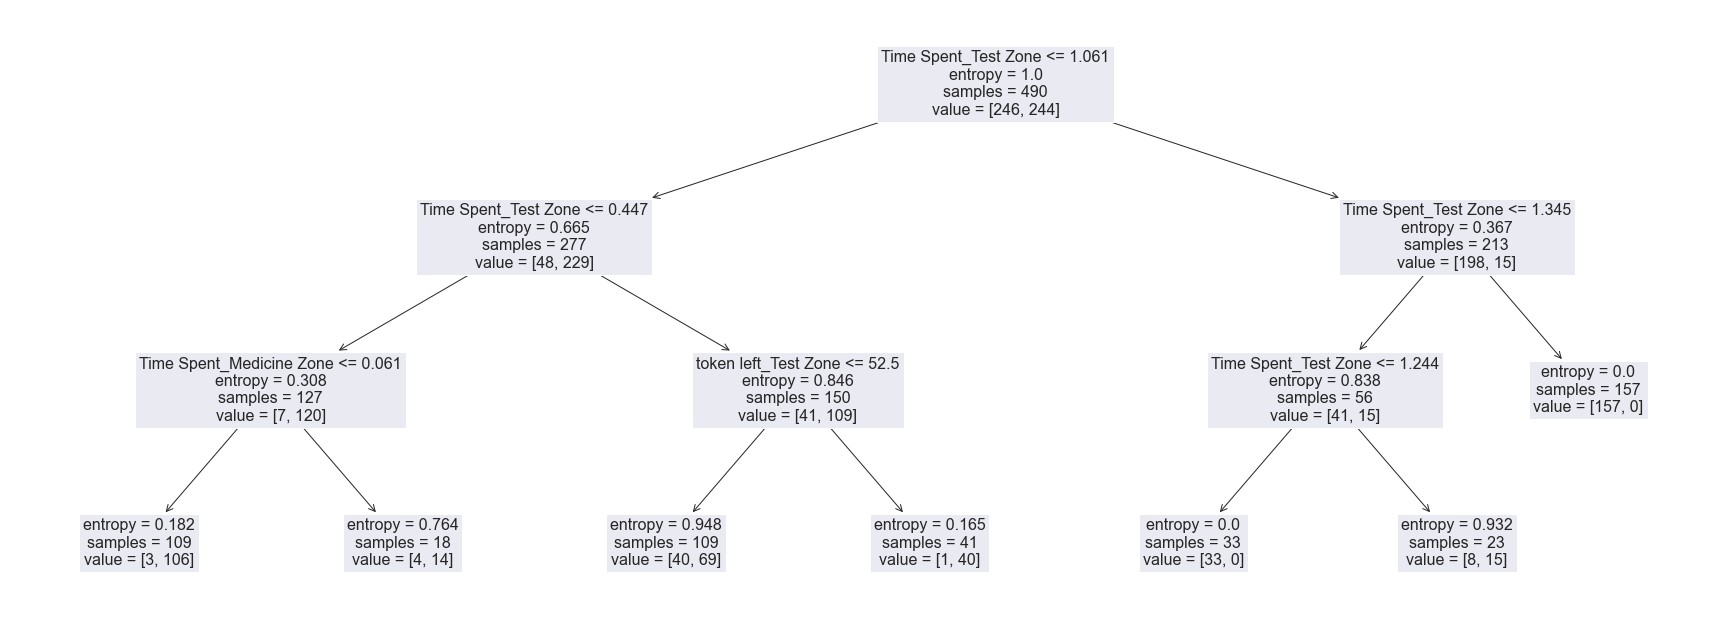

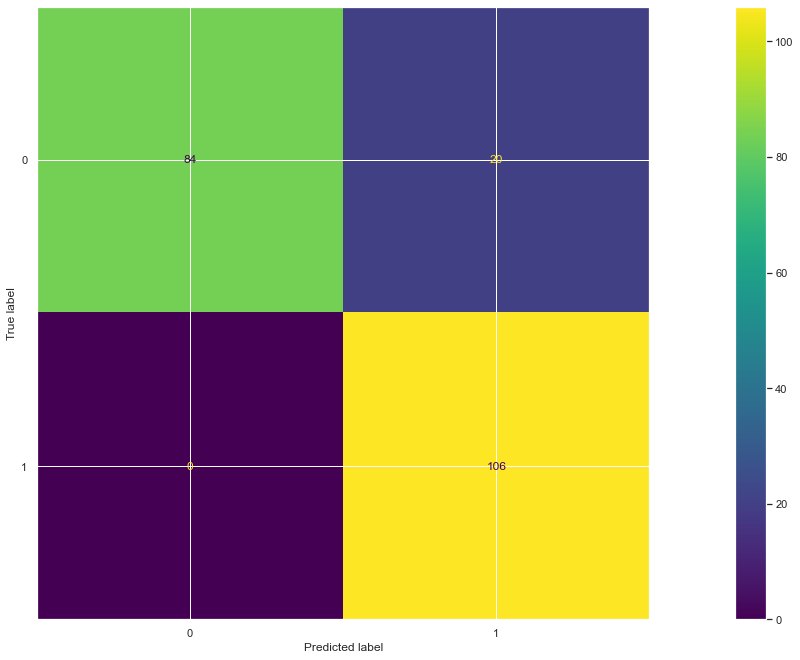

feature- Strange_AverageTimeSpent :  Day : 28
Mean absolute error LR- 0.07981220657276995
Mean Squared error LR- 0.28251054240996026
Accuracy: 0.92018779342723
F1: 0.9198414982400991
Precision: 0.920807453416149
Recall: 0.9192450495049505


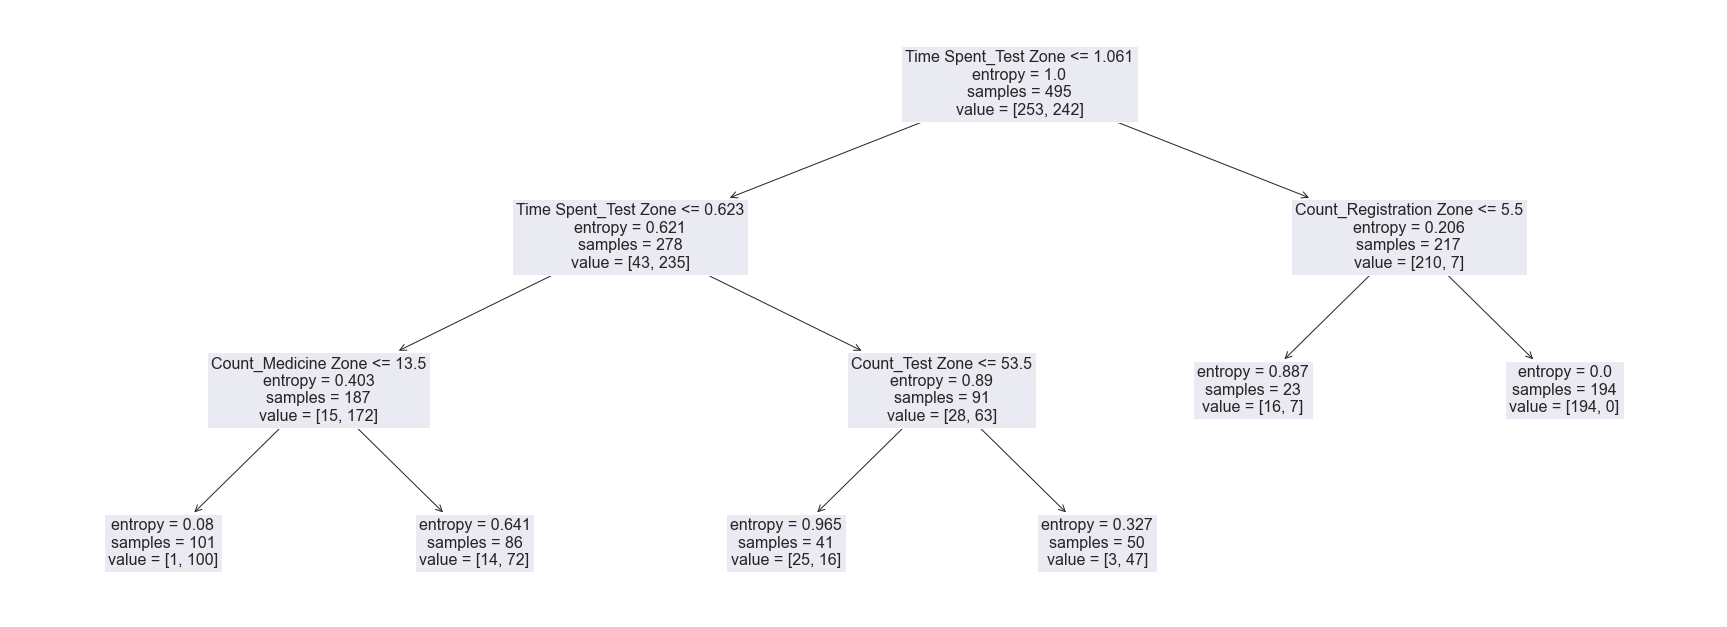

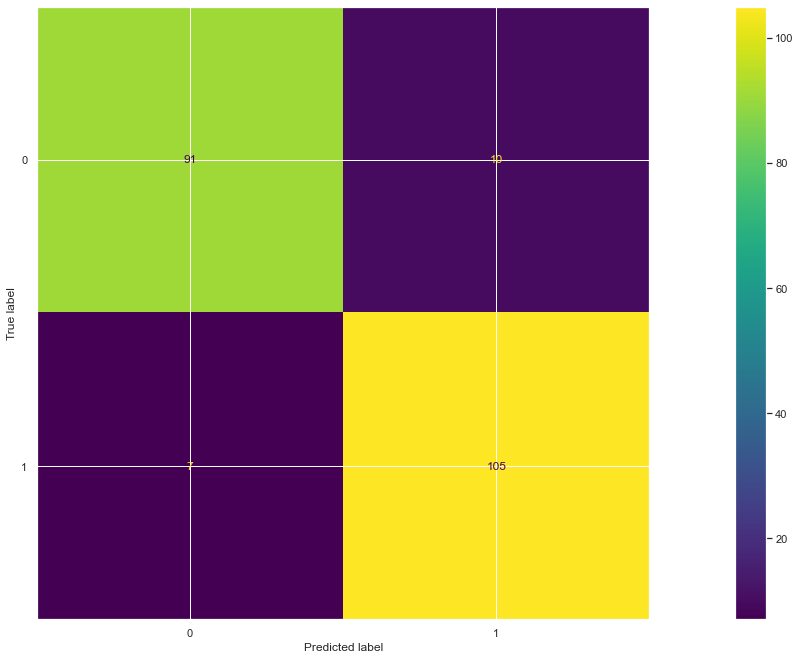

feature- Strange_AverageTimeSpent :  Day : 32
Mean absolute error LR- 0.08372093023255814
Mean Squared error LR- 0.28934569330224724
Accuracy: 0.9162790697674419
F1: 0.9153098739495799
Precision: 0.9296875
Recall: 0.9142857142857144


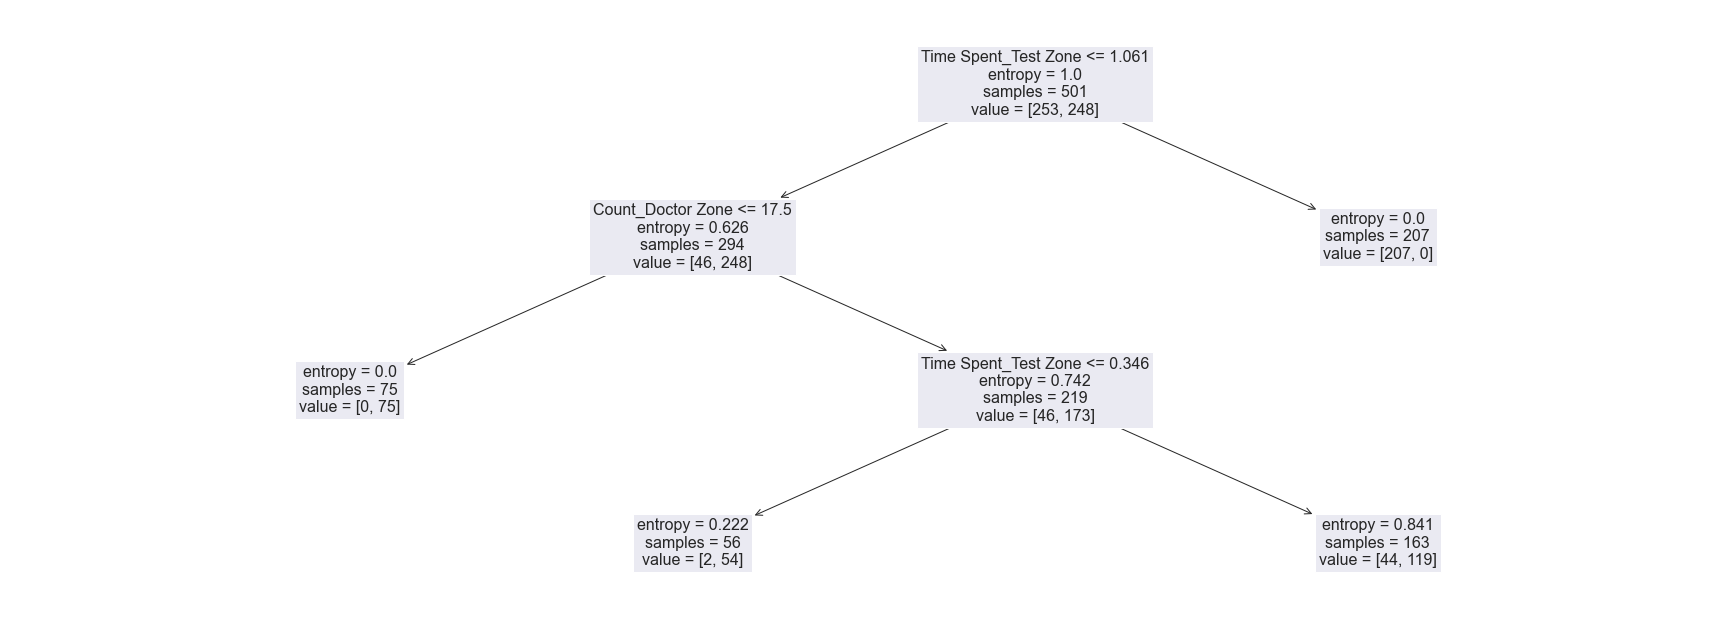

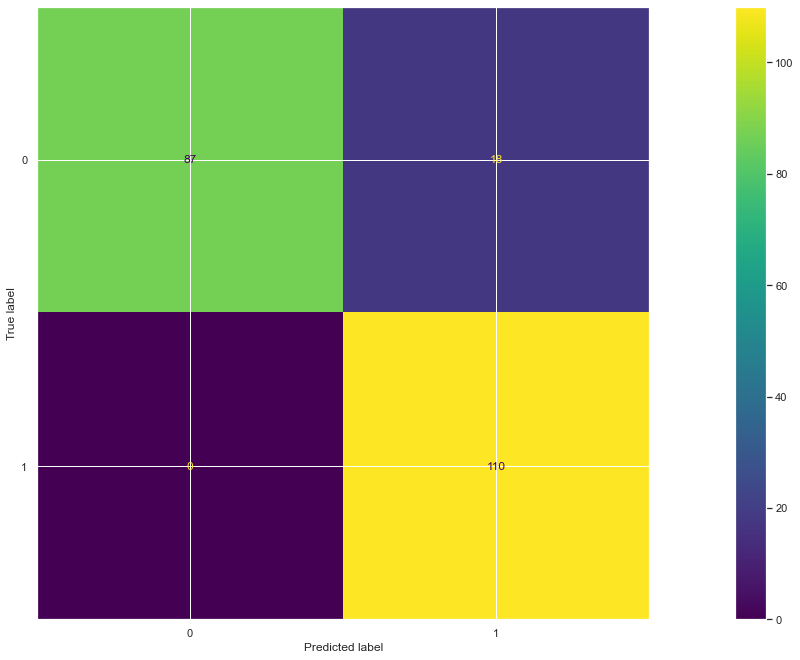

feature- Strange_AverageTimeSpent :  Day : 33
Mean absolute error LR- 0.09722222222222222
Mean Squared error LR- 0.31180478223116176
Accuracy: 0.9027777777777778
F1: 0.9021718032221192
Precision: 0.9012870012870013
Recall: 0.9078304848273456


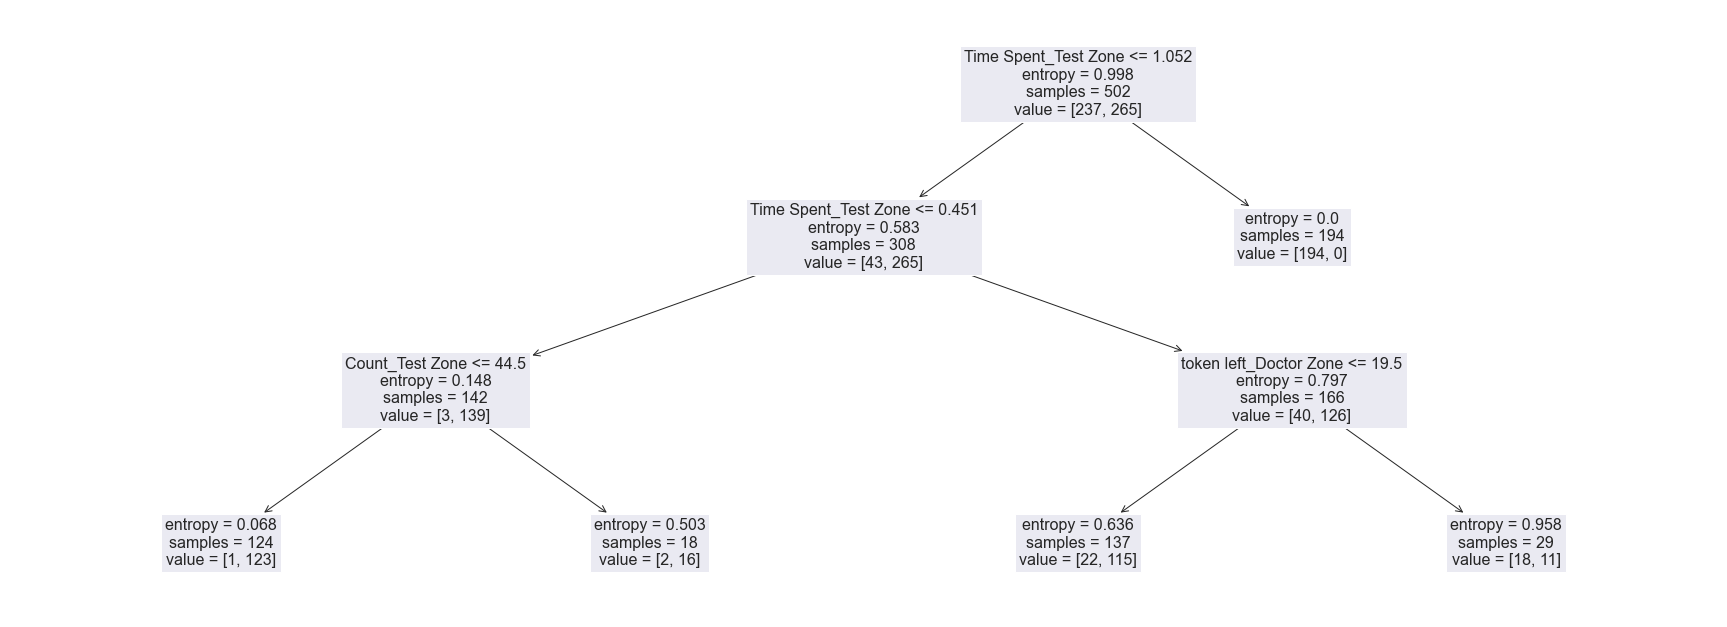

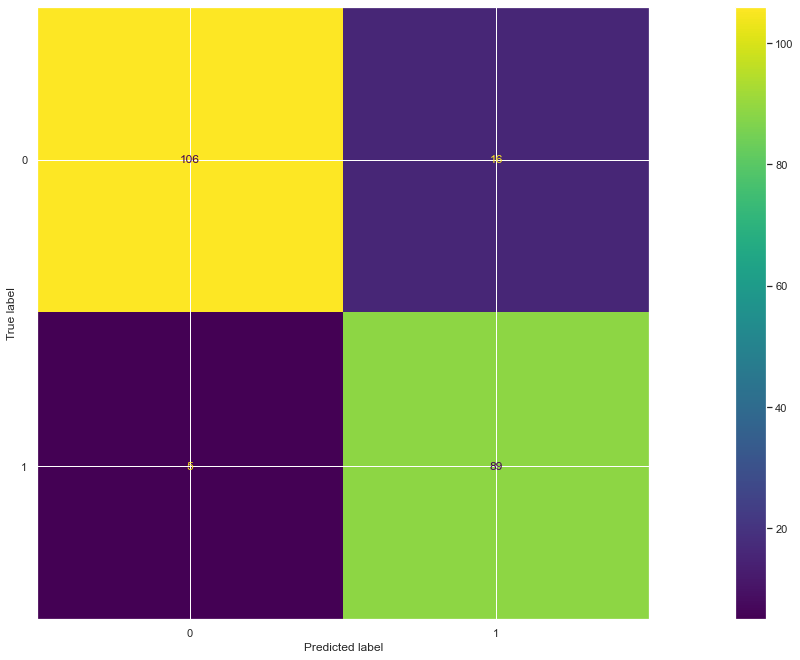

feature- Strange_AverageTimeSpent :  Day : 34
Mean absolute error LR- 0.09722222222222222
Mean Squared error LR- 0.31180478223116176
Accuracy: 0.9027777777777778
F1: 0.9027590198726607
Precision: 0.9038610038610039
Recall: 0.9047987616099071


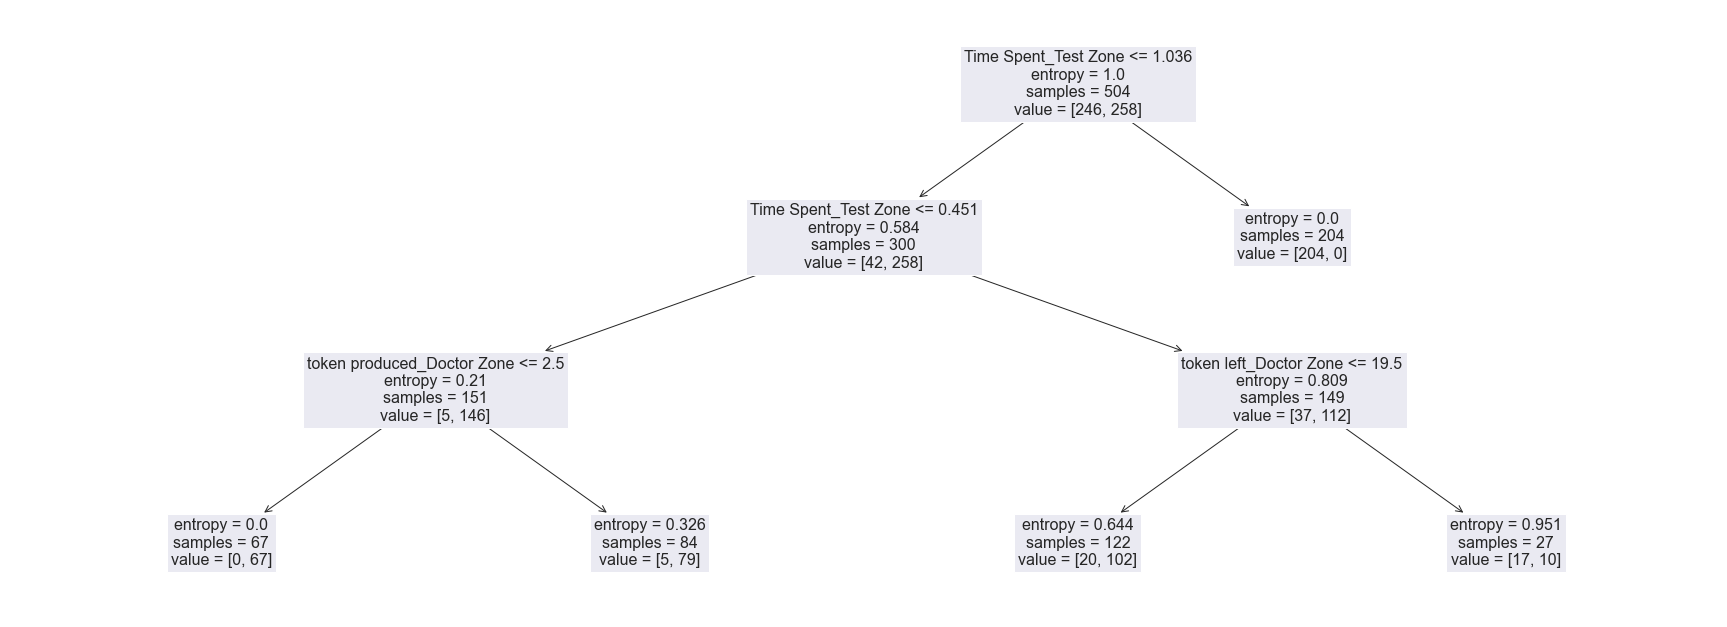

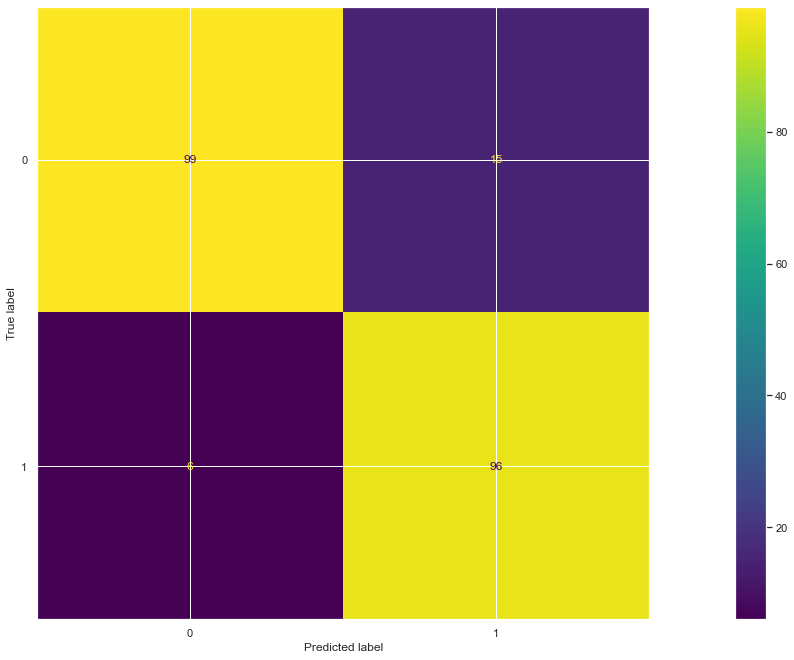

feature- Strange_AverageTimeSpent :  Day : 35
Mean absolute error LR- 0.08755760368663594
Mean Squared error LR- 0.29590134113693356
Accuracy: 0.9124423963133641
F1: 0.9118357746177697
Precision: 0.9251968503937008
Recall: 0.9128440366972477


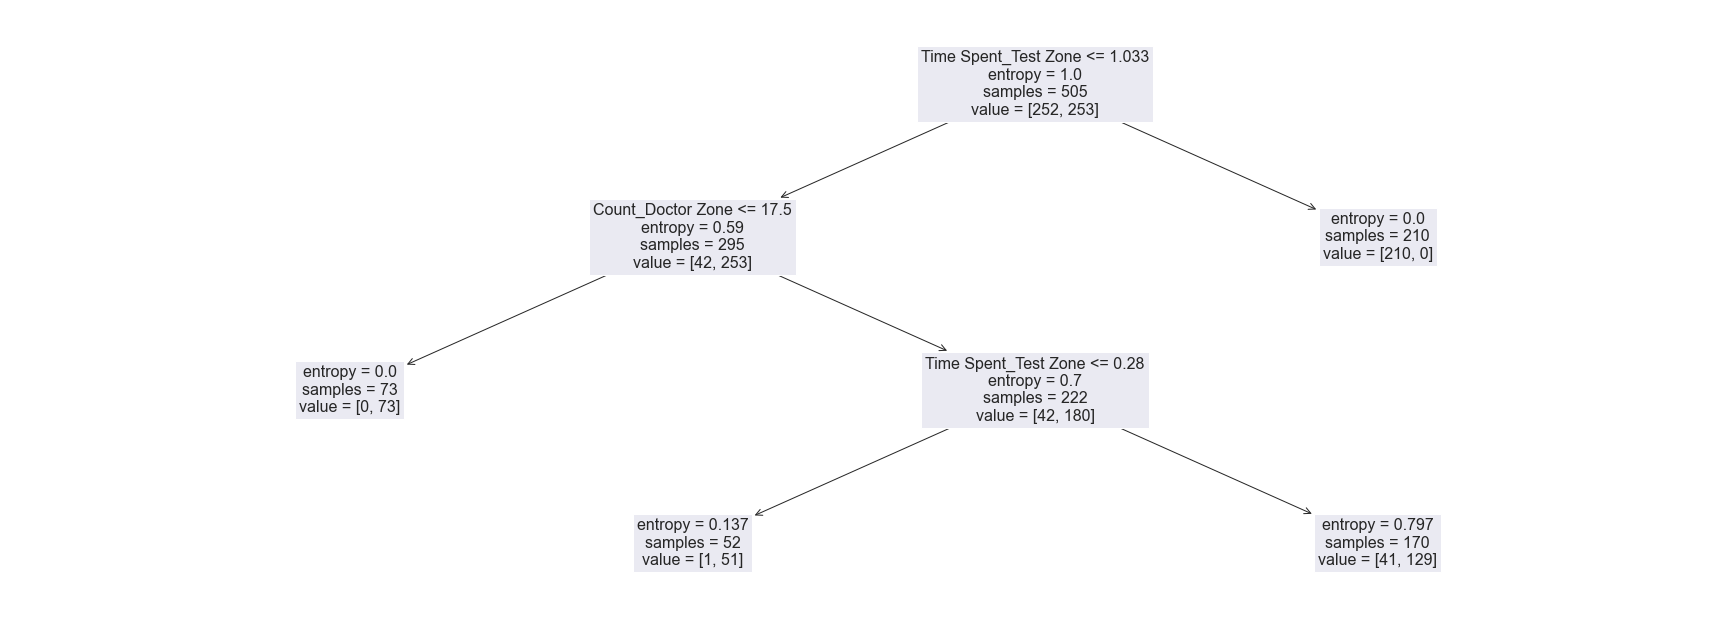

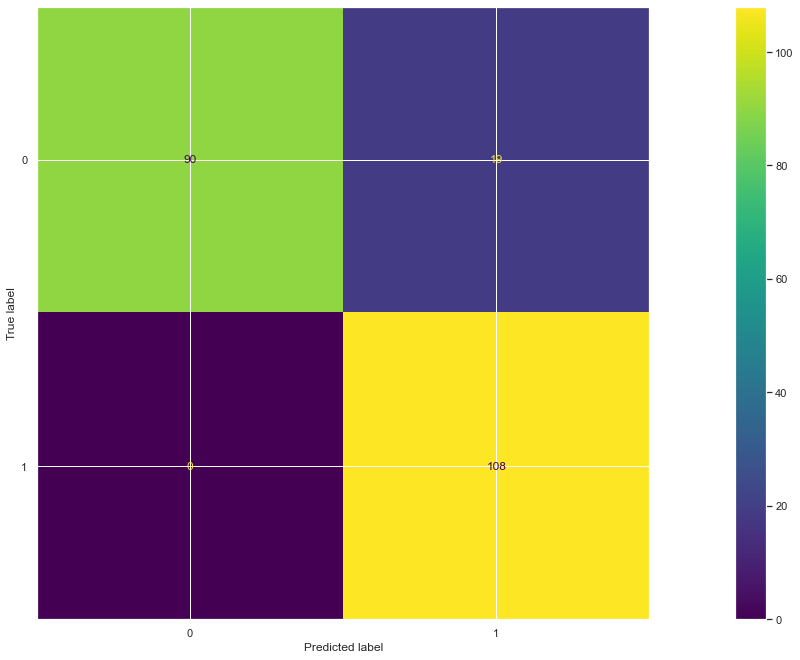

feature- Strange_AverageTimeSpent :  Day : 36
Mean absolute error LR- 0.06422018348623854
Mean Squared error LR- 0.2534170149895988
Accuracy: 0.9357798165137615
F1: 0.9354320047389355
Precision: 0.9435483870967742
Recall: 0.9351851851851851


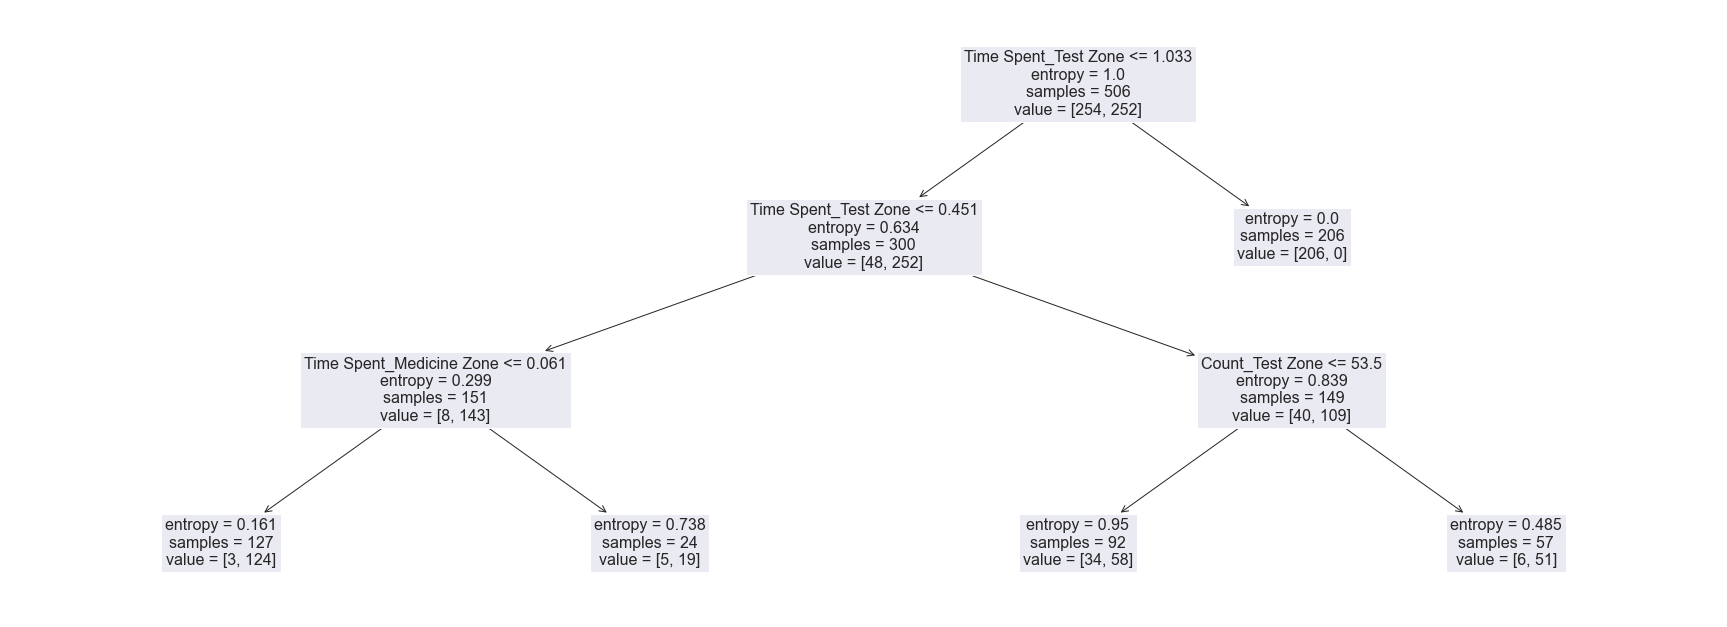

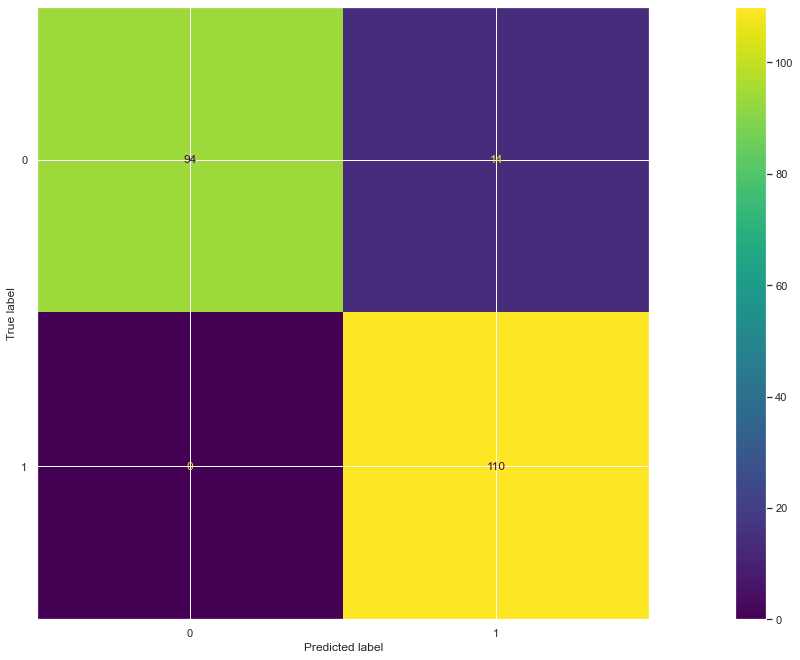

feature- Strange_AverageTimeSpent :  Day : 37
Mean absolute error LR- 0.0871559633027523
Mean Squared error LR- 0.2952218882514511
Accuracy: 0.9128440366972477
F1: 0.9126952342811373
Precision: 0.9147414741474147
Recall: 0.9125420875420875


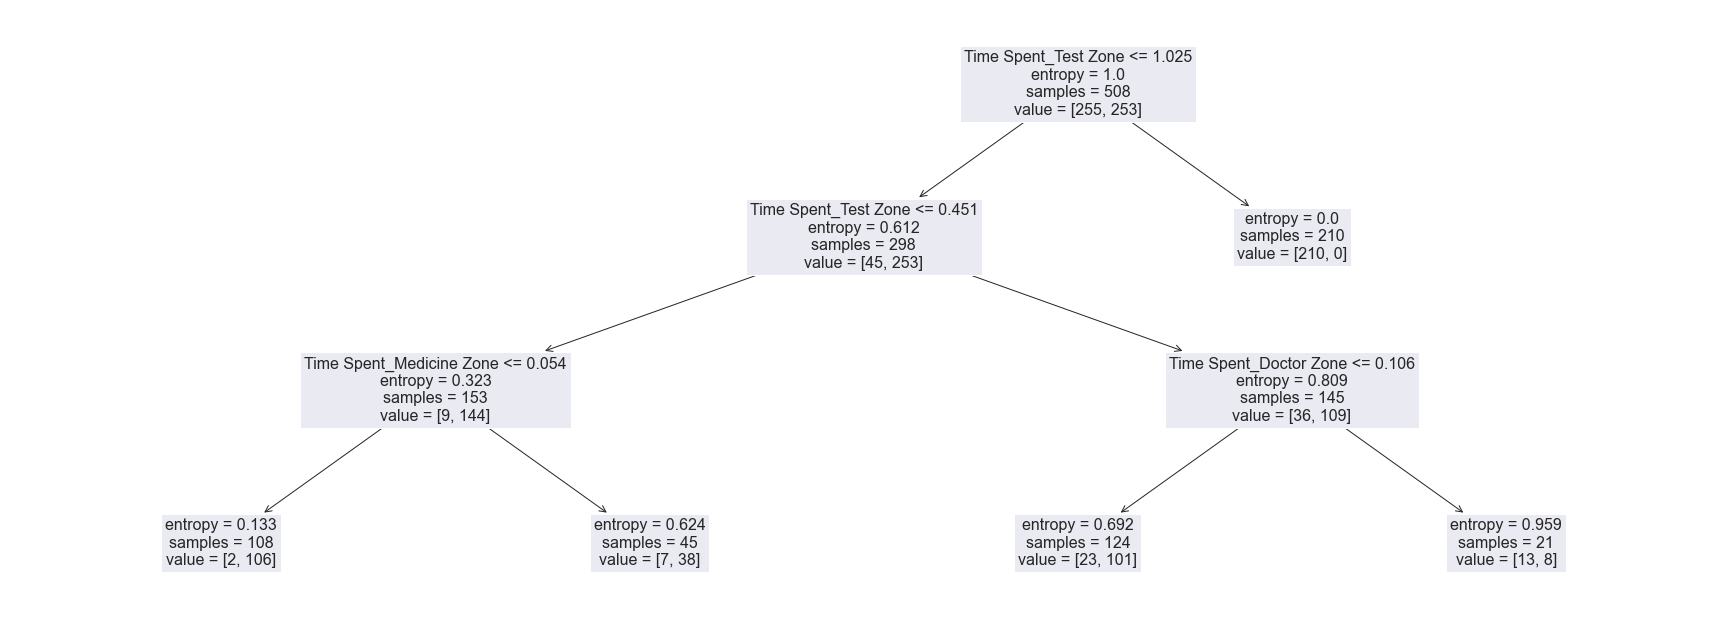

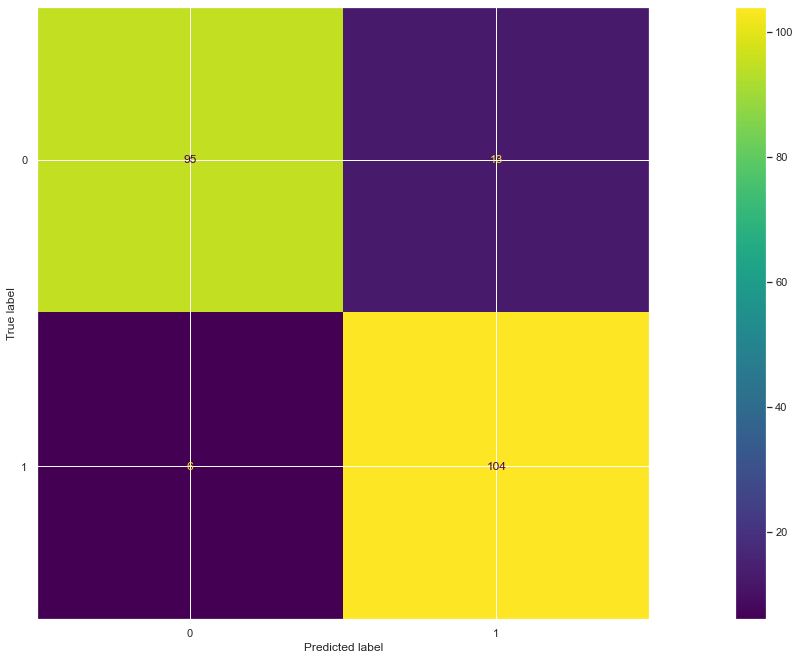

feature- Strange_AverageTimeSpent :  Day : 38
Mean absolute error LR- 0.0684931506849315
Mean Squared error LR- 0.2617119612951068
Accuracy: 0.9315068493150684
F1: 0.9314839920742517
Precision: 0.9369747899159664
Recall: 0.9347826086956521


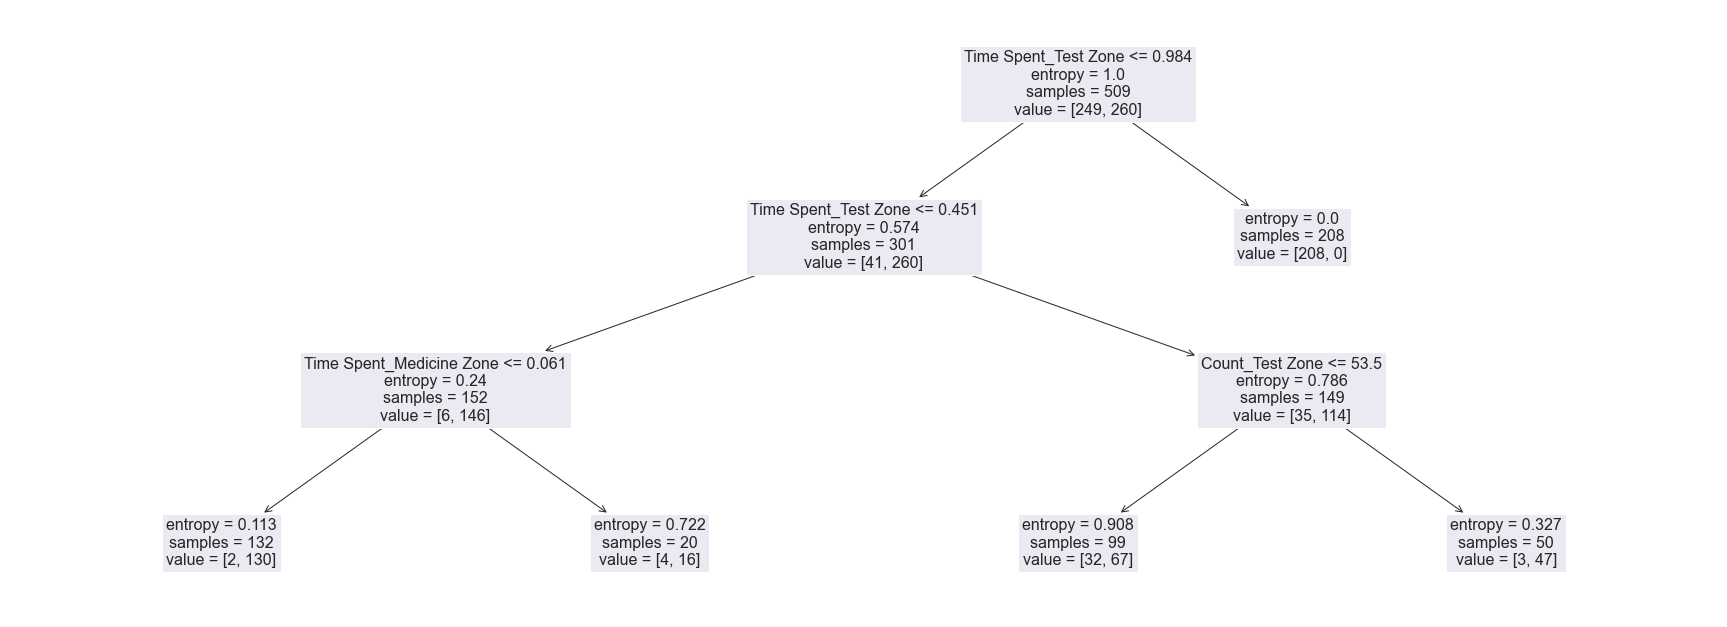

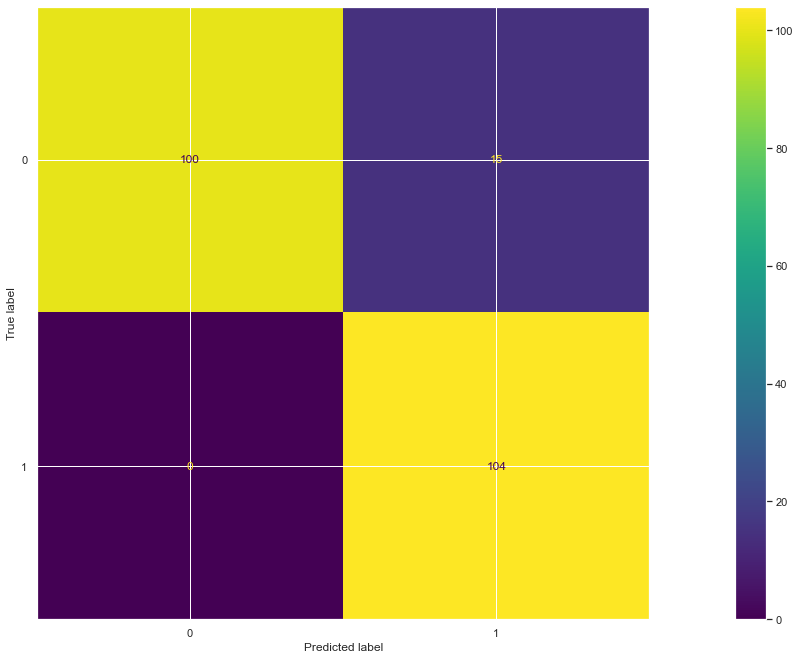

feature- Strange_AverageTimeSpent :  Day : 39
Mean absolute error LR- 0.0776255707762557
Mean Squared error LR- 0.278613658631905
Accuracy: 0.9223744292237442
F1: 0.9218464638831161
Precision: 0.9330708661417323
Recall: 0.9220183486238532


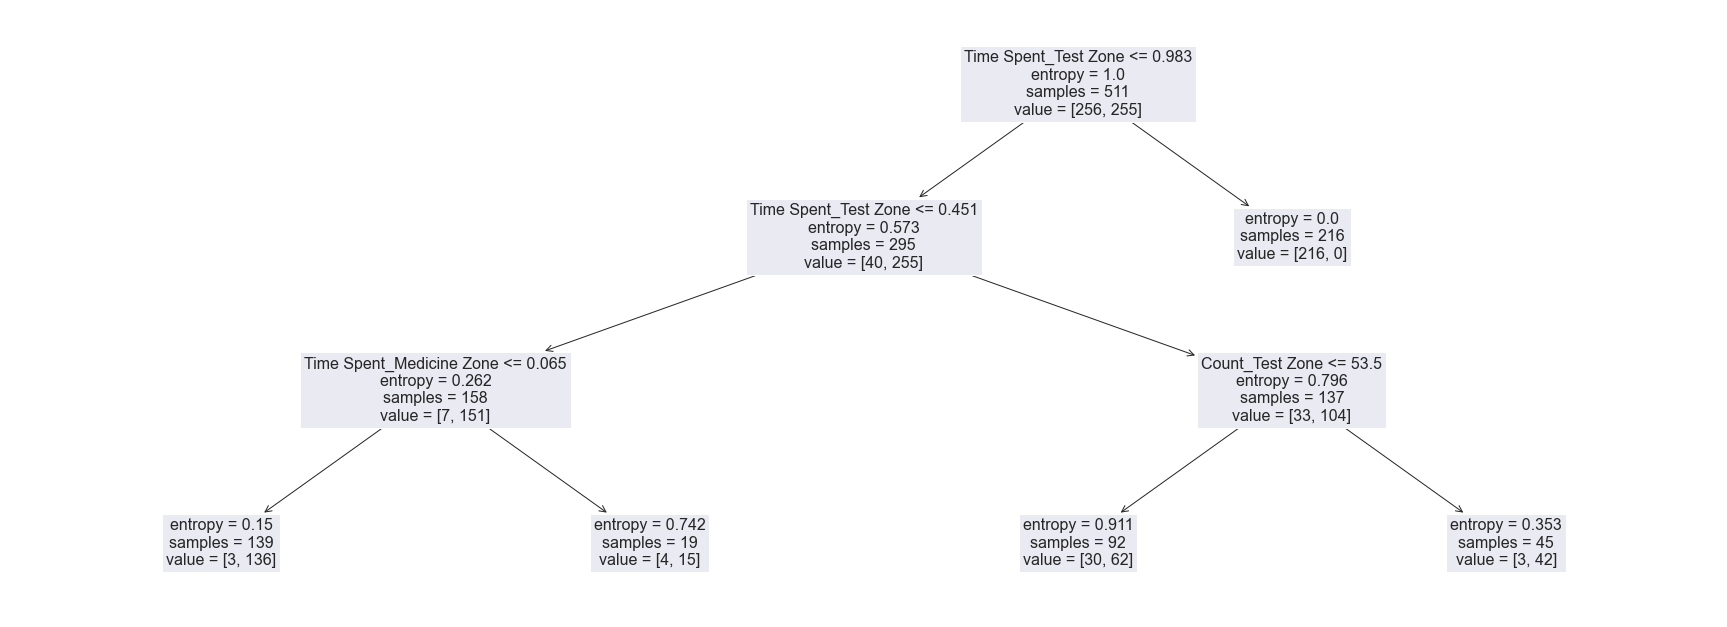

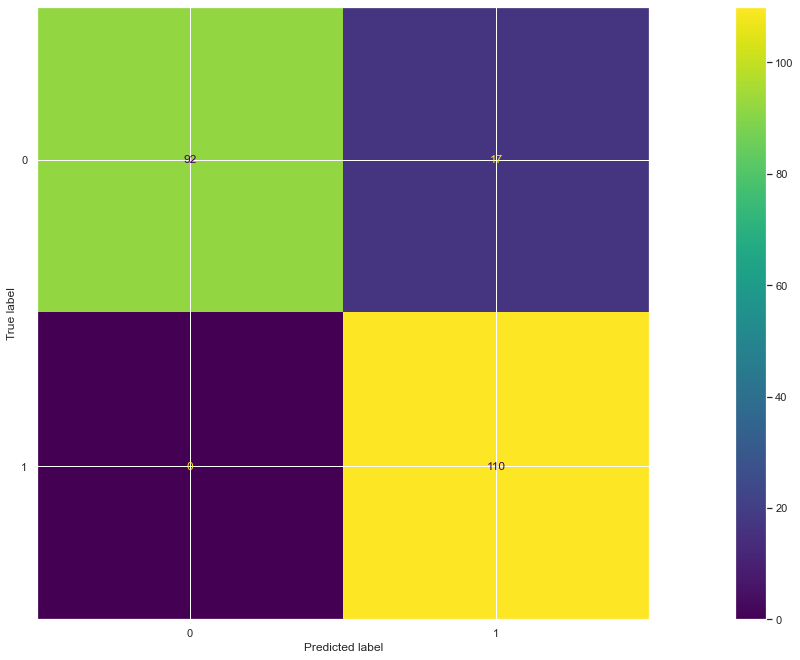

Test Zone
Doctor Zone
Medicine Zone


In [33]:
predictionDelay=40
targetfeaturelist=['Strange_tokenproduced', 'Strange_tokenconsumed', 'Strange_tokenleft','Strange_oneframetoken', 
             'Strange_Count', 'Strange_AverageTimeSpent']

for targetZone in targetzonelist:
    print(targetZone.name)
    predict(targetZone.copy(),zonelist,targetfeaturelist,predictionDelay)

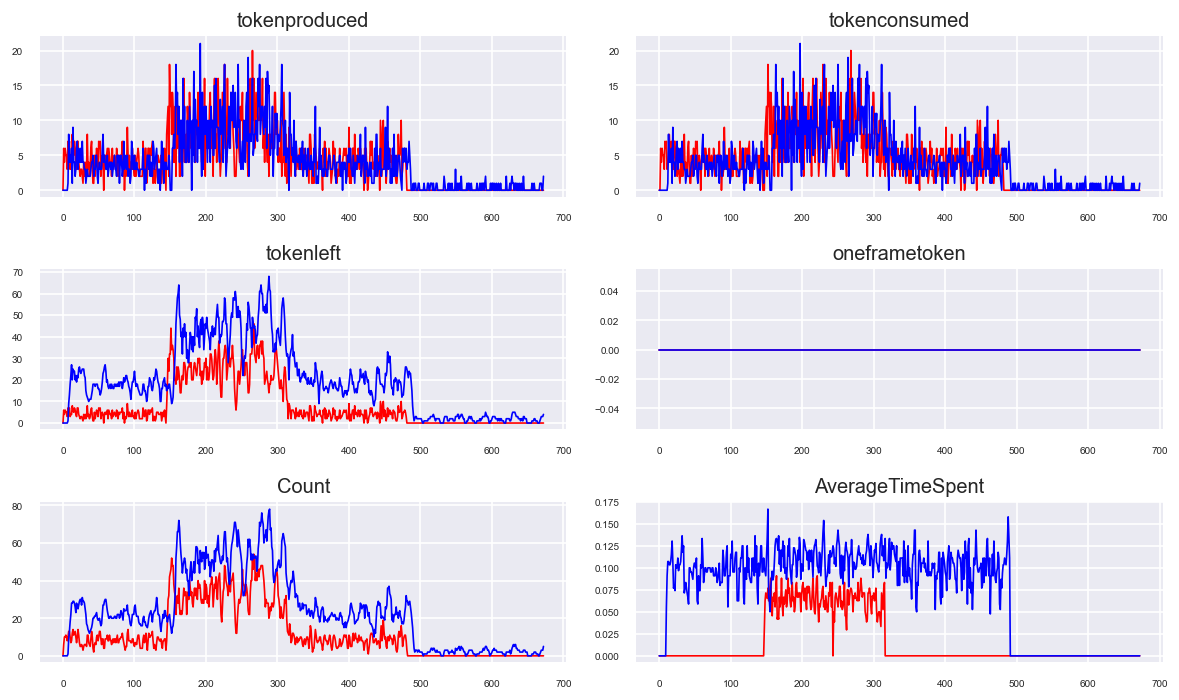

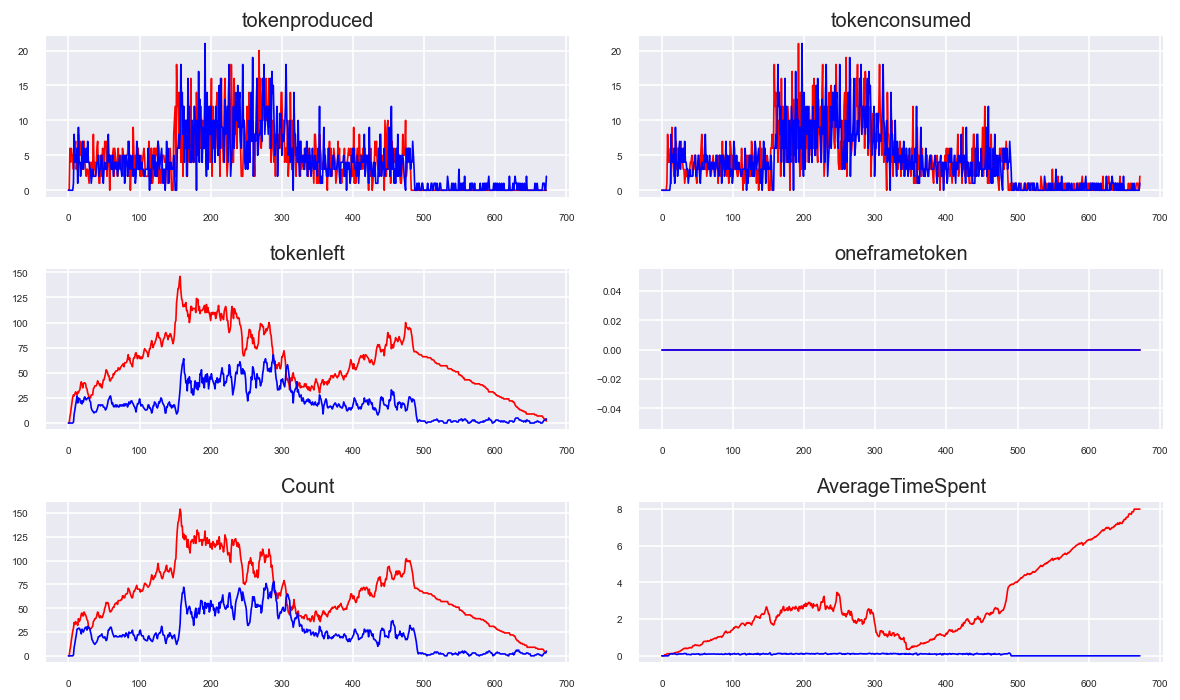

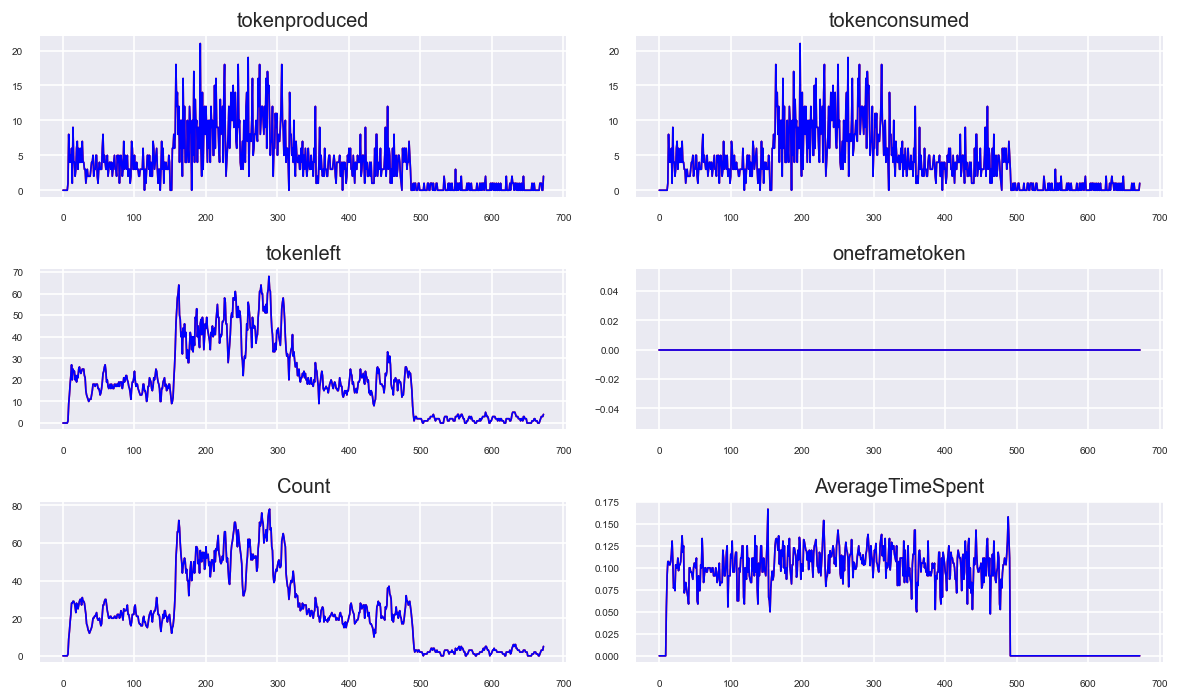

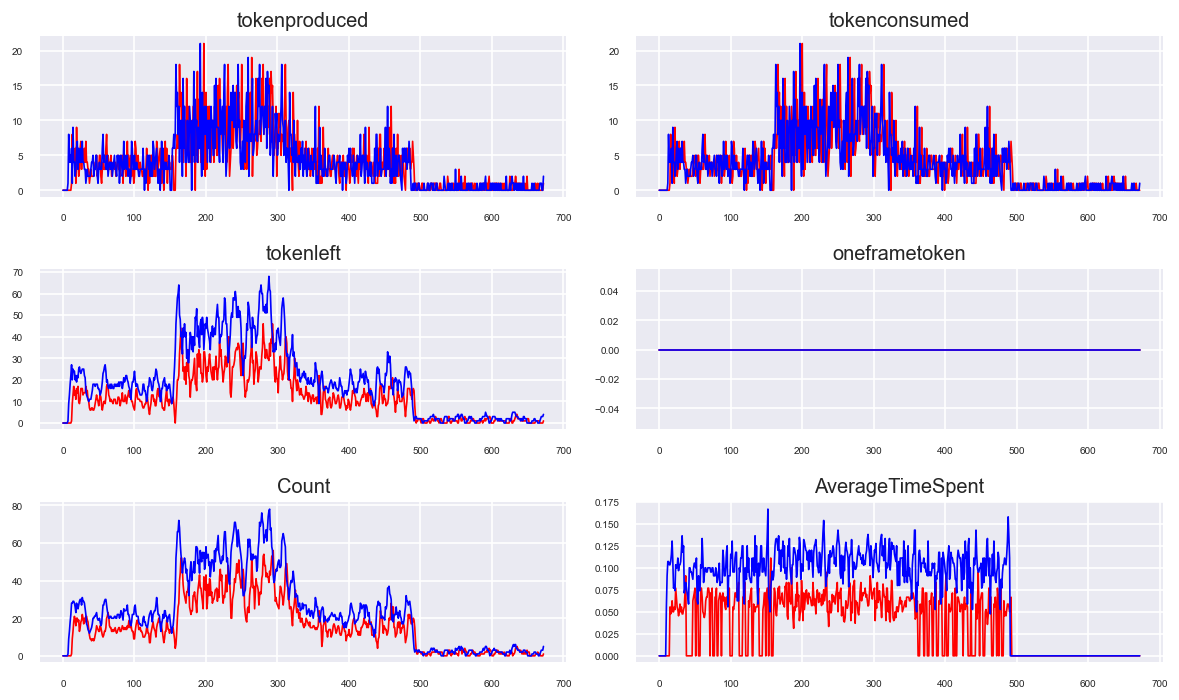

In [334]:

for zone in zonelist:
    fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        feature=featurelist[i]
        data = zone[feature]
        ax.plot(data, color='red', linewidth=1)
        ax.plot(DoctorZoneDF['tokenconsumed'], color='blue', linewidth=1)
        
        # Decorations
        ax.set_title(feature)
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout();
     

# Creating the combined dataframe

In [329]:
import datetime
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn import tree,metrics
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
sns.set(rc={'figure.figsize':(7.7,7.27)})
def traindtmultiple(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    clf = tree.DecisionTreeRegressor(max_depth=10)
    clf = clf.fit(x_train, y_train)
    prediction=clf.predict(x_test)
    #tree.plot_tree(clf,feature_names=['tokenproduced_x', 'tokenconsumed_x', 'tokenleft_x',
    #              'oneframetoken_x', 'Count_x', 'DaysSpent_x', 'AverageTimeSpent_x','tokenproduced_y',
    #              'tokenconsumed_y', 'tokenleft_y', 'oneframetoken_y','Count_y', 'DaysSpent_y', 'AverageTimeSpent_y',
    #              'tokenproduced','tokenconsumed', 'tokenleft', 'oneframetoken','Count', 'DaysSpent',
    #              'AverageTimeSpent'])
    Y_test_pred = pd.DataFrame(prediction).applymap(lambda x: 1 if x>0.5 else 0)
    #Y_test_pred = pd.DataFrame(prediction)
    if accuracy_score(y_test, Y_test_pred)>0.8 and f1_score(y_test, Y_test_pred, average="macro")>0.8:
        print("Mean absolute error LR-",metrics.mean_absolute_error(y_test, Y_test_pred))
        metrics.mean_squared_error(y_test, Y_test_pred)
        print("Mean Squared error LR-",np.sqrt(metrics.mean_squared_error(y_test, Y_test_pred)))
        print("Accuracy:",accuracy_score(y_test, Y_test_pred))
        print("F1:",f1_score(y_test, Y_test_pred, average="macro"))
        print("Precision:",precision_score(y_test, Y_test_pred, average="macro"))
        print("Recall:",recall_score(y_test, Y_test_pred, average="macro"))
        cm = confusion_matrix(y_test, Y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()



In [16]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

In [15]:
!pip install imblearn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.0
    Uninstalling joblib-1.0.0:
      Successfully uninstalled joblib-1.0.0


In [98]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
sns.set(rc={'figure.figsize':(40.7,11.27)})
def traindtmultiple(x,y,columnlist,feature,i):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    clf = tree.DecisionTreeClassifier(max_depth=5,class_weight='balanced')
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
    scores = cross_val_score(clf, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
    print('feature-',feature,':',' Day :',i)
        
    print('Mean ROC AUC: %.3f' % mean(scores))
    clf = clf.fit(x_train, y_train)
    prediction=clf.predict(x_test)
    Y_test_pred = pd.DataFrame(prediction).applymap(lambda x: 1 if x>0.5 else 0)
    #Y_test_pred = pd.DataFrame(prediction)
    if accuracy_score(y_test, Y_test_pred)>0.7 and accuracy_score(y_test, Y_test_pred)<1 and f1_score(y_test, Y_test_pred, average="macro")>0.7:
        print('feature-',feature,':',' Day :',i)
        print("Mean absolute error LR-",metrics.mean_absolute_error(y_test, Y_test_pred))
        metrics.mean_squared_error(y_test, Y_test_pred)
        print("Mean Squared error LR-",np.sqrt(metrics.mean_squared_error(y_test, Y_test_pred)))
        print("Accuracy:",accuracy_score(y_test, Y_test_pred))
        print("F1:",f1_score(y_test, Y_test_pred, average="macro"))
        print("Precision:",precision_score(y_test, Y_test_pred, average="macro"))
        print("Recall:",recall_score(y_test, Y_test_pred, average="macro"))
        tree.plot_tree(clf,feature_names=columnlist,fontsize=12)
        plt.rcParams.update({'font.size': 26})

        cm = confusion_matrix(y_test, Y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()



def predict(targetZone,predictorZone,featurelist,predictionDelay):
    for feature in featurelist:
        combineddata=None
        for i in range(len(predictorZone)):
            if combineddata is None:
                combineddata=pd.merge(predictorZone[0],predictorZone[1],on=['date'],how='left',suffixes=("_"+predictorZone[0].name, "_"+predictorZone[1].name))
                combineddata['tokenproduced']=0
                combineddata['tokenconsumed']=0
                combineddata['tokenleft']=0
                combineddata['Count']=0
                combineddata['oneframetoken']=0
                combineddata['AverageTimeSpent']=0
            elif i>1:
                combineddata=combineddata.merge(predictorZone[i],on=['date'],how='left',suffixes=(None,"_"+predictorZone[i].name))
            
        def categorise(row,numdays):   
            return row['date'] -  datetime.timedelta(hours=1)
        for j in range (predictionDelay):
            combineddata=combineddata.merge(targetZone[['date',feature]].rename({feature: feature+'_'+str(j)}, axis=1), on='date', how='left')
            targetZone['date'] = targetZone.apply(lambda row: categorise(row,j), axis=1)
        combineddata=combineddata.dropna()
        for j in range (predictionDelay):
            combineddata[feature+'_'+str(j)] = combineddata[feature+'_'+str(j)].astype(int)
        
        columnlist=[]
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('token')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('oneframetoken')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('DaysSpent')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('AverageTimeSpent')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('Count')].columns)
        x = combineddata[columnlist]
        for i in range(predictionDelay):
            
            y = combineddata[feature+'_'+str(i)].fillna(0).copy()
            x = combineddata[columnlist].copy()
            traindtmultiple(x,y,columnlist,feature,i)


Medicine Zone
feature- Strange_tokenproduced :  Day : 0
Mean ROC AUC: 0.916
feature- Strange_tokenproduced :  Day : 0
Mean absolute error LR- 0.11450381679389313
Mean Squared error LR- 0.3383841260962061
Accuracy: 0.8854961832061069
F1: 0.862056862056862
Precision: 0.8648839841539332
Recall: 0.8593924191750278


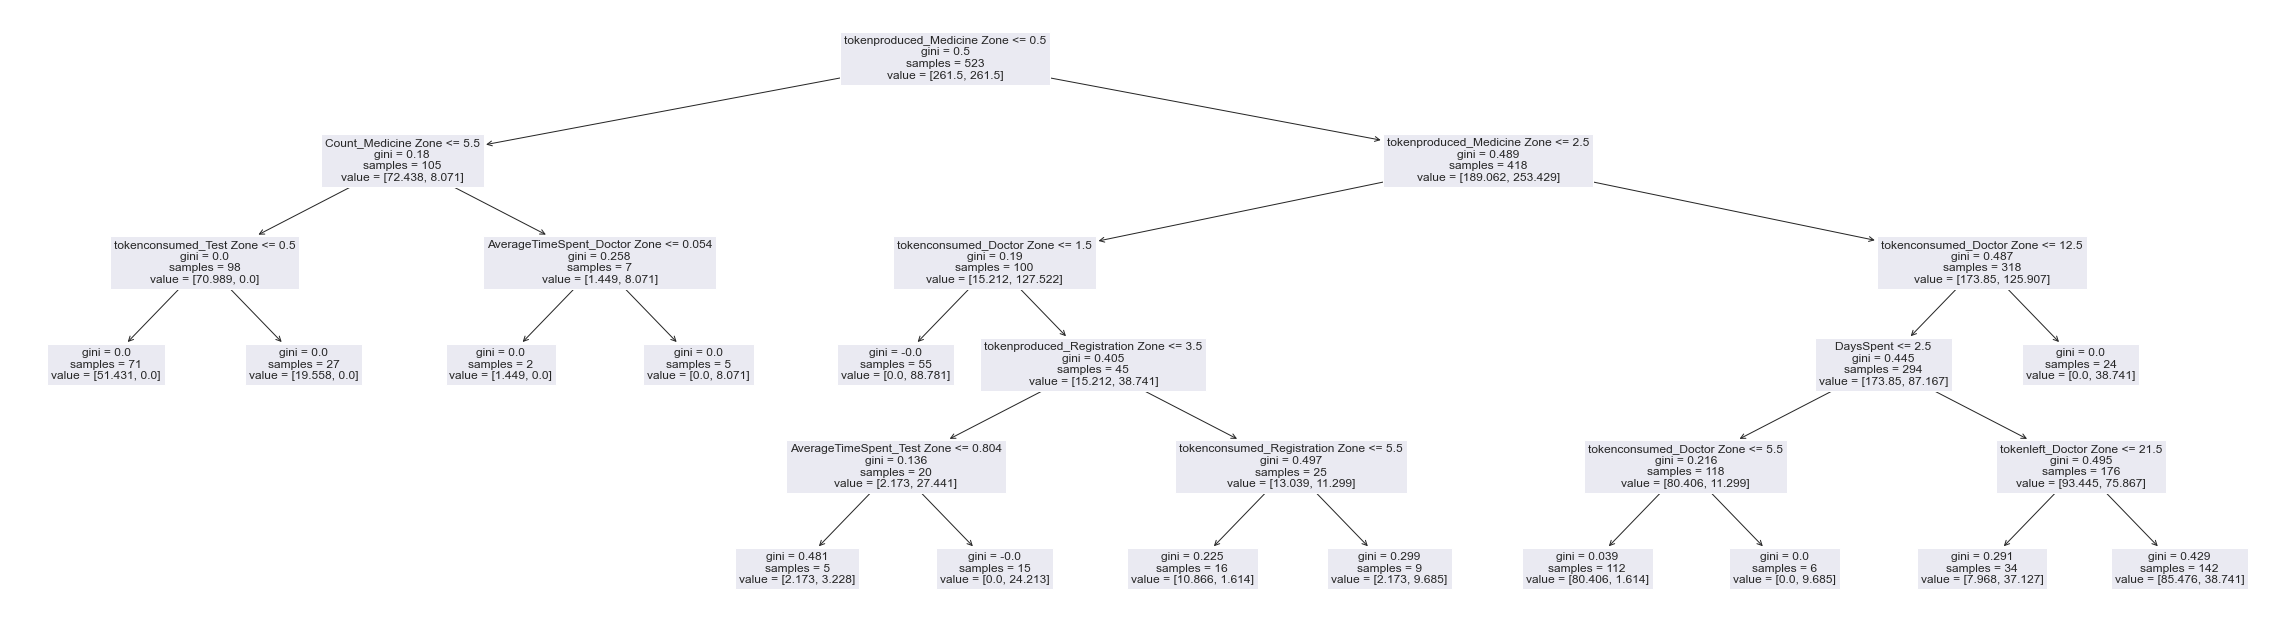

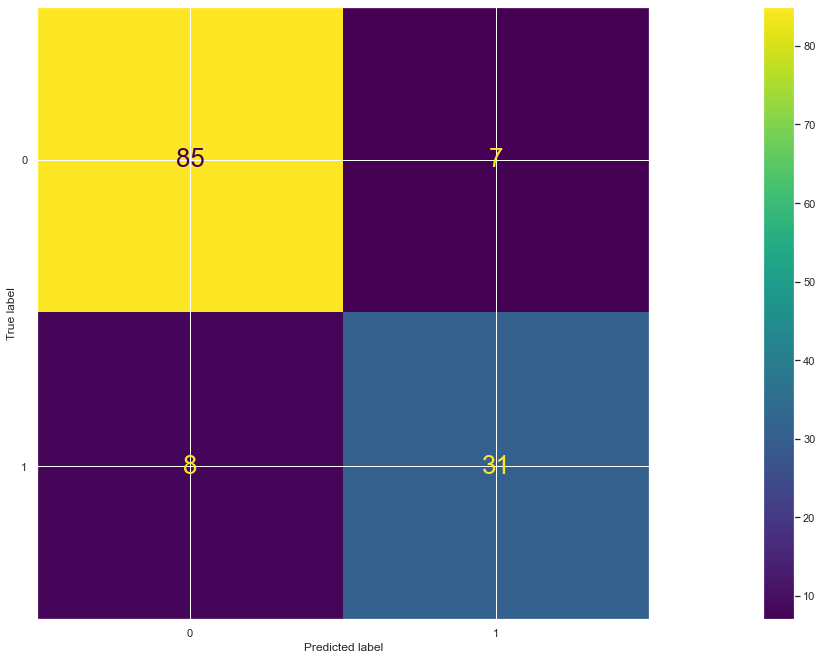

feature- Strange_tokenproduced :  Day : 1
Mean ROC AUC: 0.580
feature- Strange_tokenproduced :  Day : 2
Mean ROC AUC: 0.580
feature- Strange_tokenproduced :  Day : 3
Mean ROC AUC: 0.542
feature- Strange_tokenproduced :  Day : 4
Mean ROC AUC: 0.572
feature- Strange_tokenproduced :  Day : 5
Mean ROC AUC: 0.935
feature- Strange_tokenproduced :  Day : 5
Mean absolute error LR- 0.06870229007633588
Mean Squared error LR- 0.2621112169983114
Accuracy: 0.9312977099236641
F1: 0.9130595088857754
Precision: 0.8971420486700623
Recall: 0.933982683982684


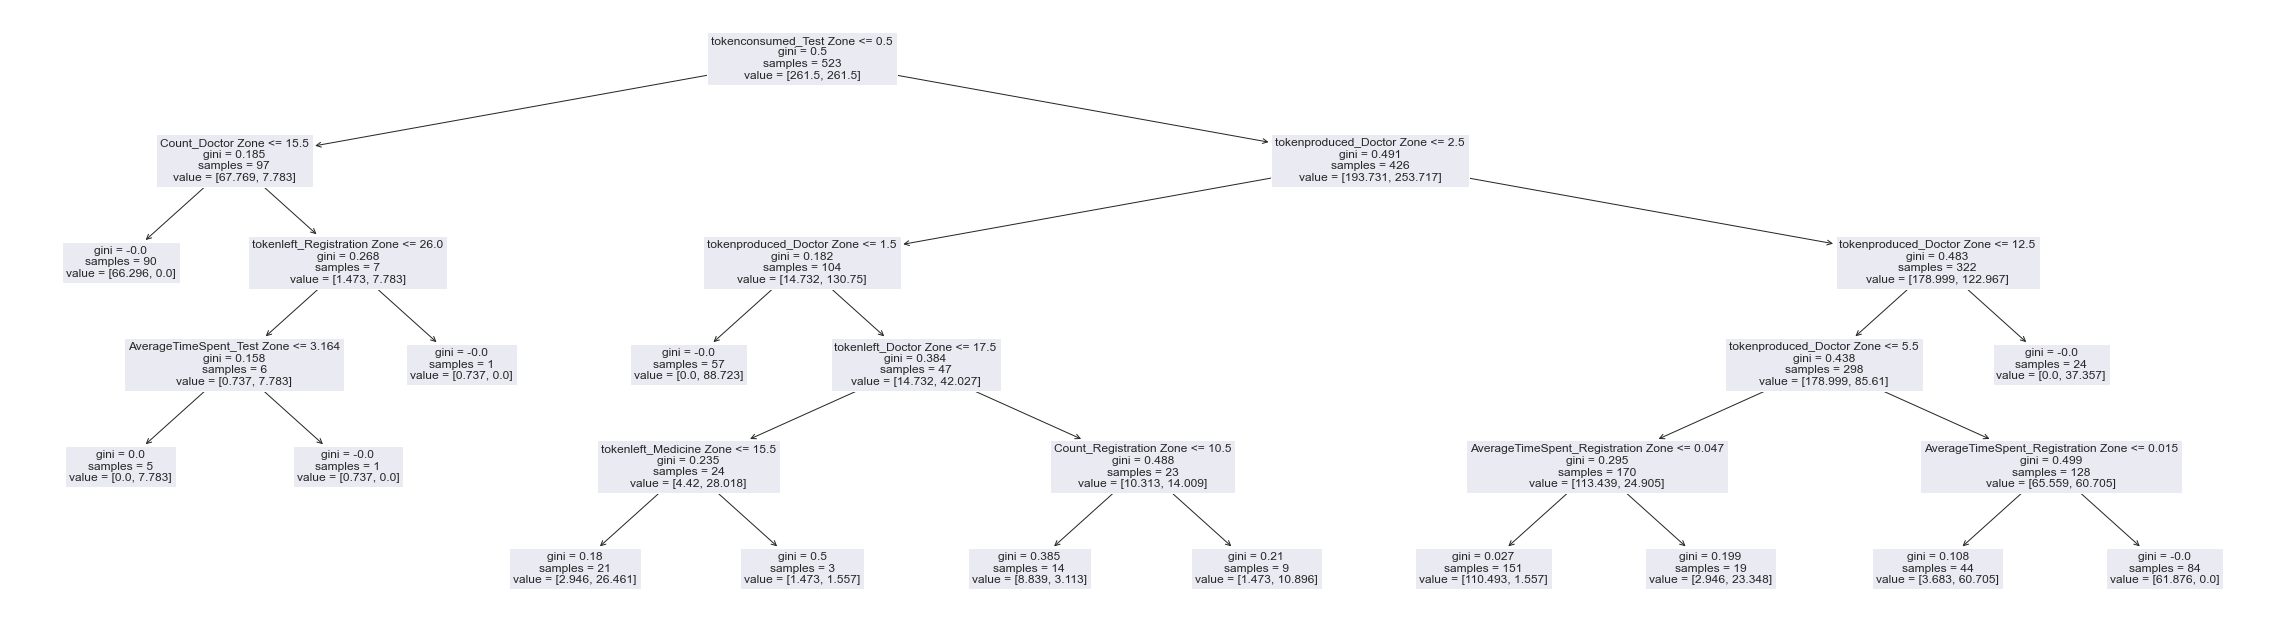

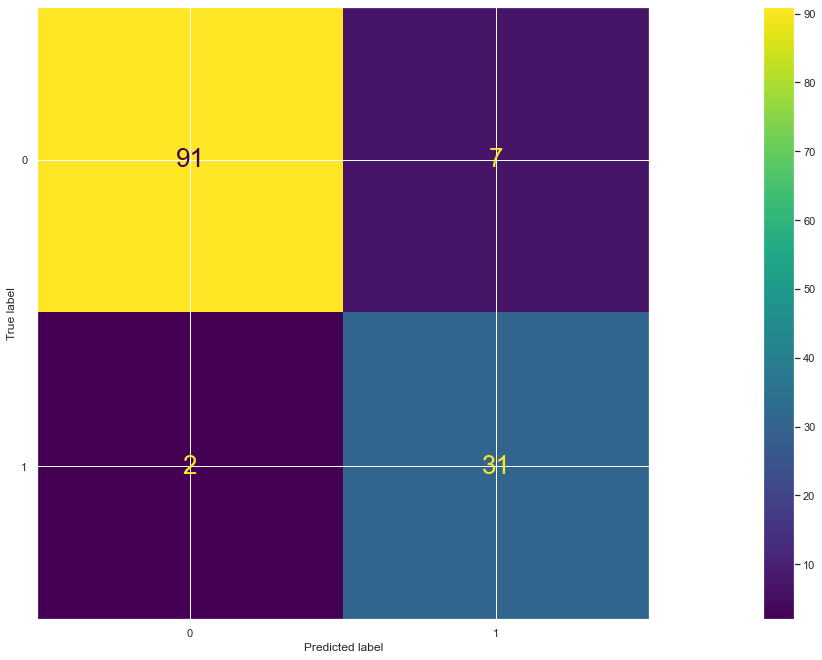

feature- Strange_tokenproduced :  Day : 6
Mean ROC AUC: 0.496
feature- Strange_tokenproduced :  Day : 7
Mean ROC AUC: 0.491
feature- Strange_tokenproduced :  Day : 8
Mean ROC AUC: 0.509
feature- Strange_tokenproduced :  Day : 9
Mean ROC AUC: 0.493
feature- Strange_tokenproduced :  Day : 10
Mean ROC AUC: 0.505
feature- Strange_tokenproduced :  Day : 11
Mean ROC AUC: 0.508
feature- Strange_tokenproduced :  Day : 12
Mean ROC AUC: 0.489
feature- Strange_tokenproduced :  Day : 13
Mean ROC AUC: 0.485
feature- Strange_tokenproduced :  Day : 14
Mean ROC AUC: 0.524
feature- Strange_tokenproduced :  Day : 15
Mean ROC AUC: 0.492
feature- Strange_tokenproduced :  Day : 16
Mean ROC AUC: 0.480
feature- Strange_tokenproduced :  Day : 17
Mean ROC AUC: 0.536
feature- Strange_tokenproduced :  Day : 18
Mean ROC AUC: 0.542
feature- Strange_tokenproduced :  Day : 19
Mean ROC AUC: 0.508
feature- Strange_tokenconsumed :  Day : 0
Mean ROC AUC: 0.494
feature- Strange_tokenconsumed :  Day : 1
Mean ROC AUC: 0.54

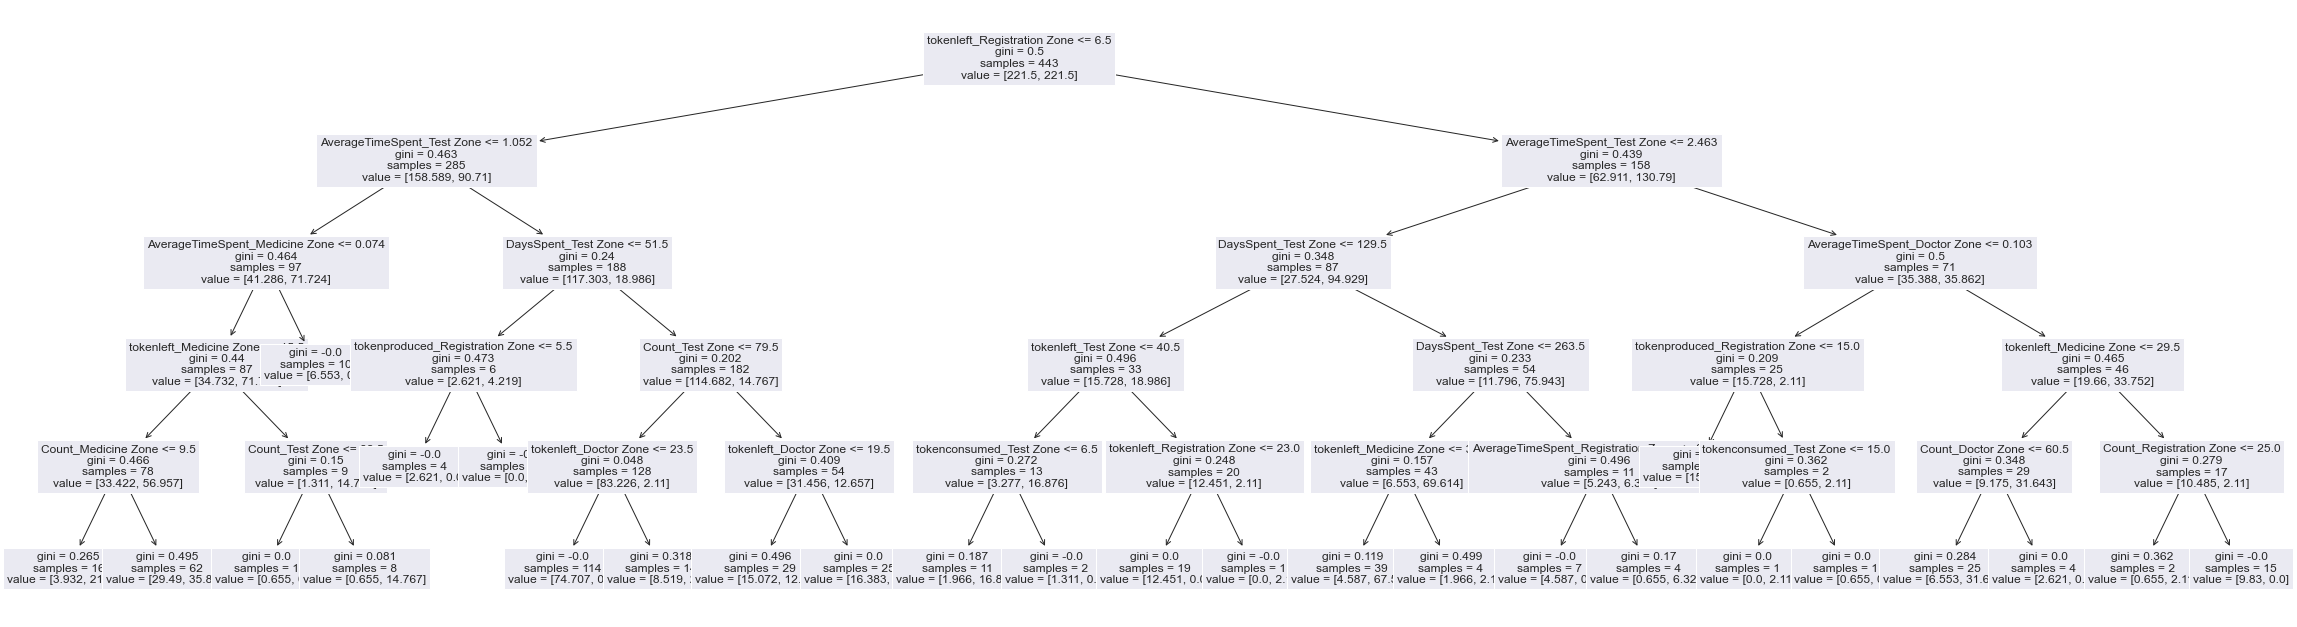

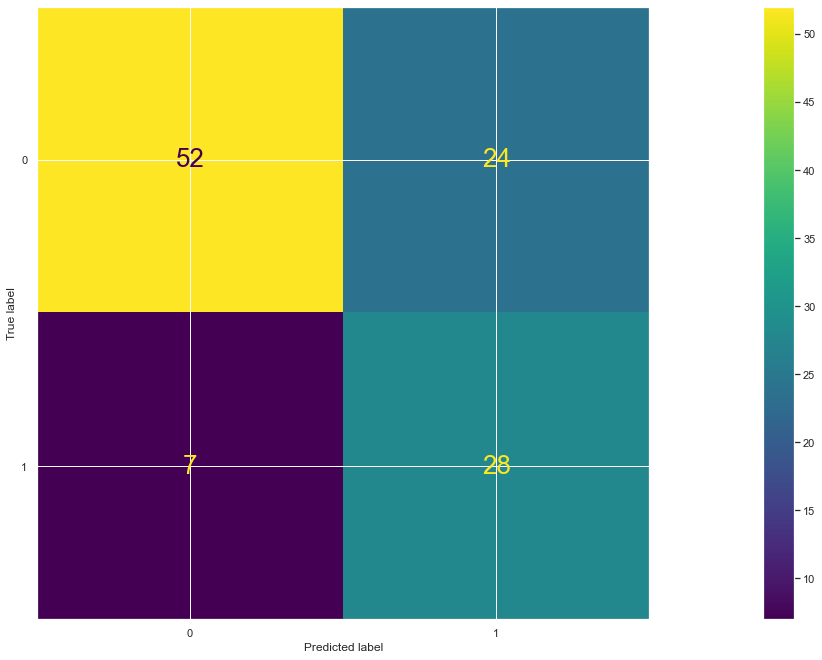

feature- Strange_AverageTimeSpent :  Day : 16
Mean ROC AUC: 0.720
feature- Strange_AverageTimeSpent :  Day : 17
Mean ROC AUC: 0.706
feature- Strange_AverageTimeSpent :  Day : 18
Mean ROC AUC: 0.748
feature- Strange_AverageTimeSpent :  Day : 19
Mean ROC AUC: 0.738


In [101]:
predictionDelay=20
targetfeaturelist=['Strange_tokenproduced', 'Strange_tokenconsumed', 'Strange_tokenleft','Strange_oneframetoken', 
             'Strange_Count', 'Strange_AverageTimeSpent']

for targetZone in targetzonelist[3:4]:
    print(targetZone.name)
    predict(targetZone.copy(),zonelist,targetfeaturelist,predictionDelay)

In [75]:
predictionDelay=10
targetfeaturelist=['Strange_tokenproduced', 'Strange_tokenconsumed', 'Strange_tokenleft','Strange_oneframetoken', 
             'Strange_Count', 'Strange_AverageTimeSpent']

for targetZone in targetzonelist[3:4]:
    print(targetZone.name)
    predict(targetZone.copy(),zonelist,targetfeaturelist,predictionDelay)

Medicine Zone
feature- Strange_tokenproduced :  Day : 0
Mean ROC AUC: 0.898
feature- Strange_tokenproduced :  Day : 1
Mean ROC AUC: 0.568
feature- Strange_tokenproduced :  Day : 2
Mean ROC AUC: 0.566
feature- Strange_tokenproduced :  Day : 3
Mean ROC AUC: 0.563
feature- Strange_tokenproduced :  Day : 4
Mean ROC AUC: 0.532
feature- Strange_tokenproduced :  Day : 5
Mean ROC AUC: 0.851
feature- Strange_tokenproduced :  Day : 6
Mean ROC AUC: 0.476
feature- Strange_tokenproduced :  Day : 7
Mean ROC AUC: 0.526
feature- Strange_tokenproduced :  Day : 8
Mean ROC AUC: 0.543
feature- Strange_tokenproduced :  Day : 9
Mean ROC AUC: 0.455
feature- Strange_tokenconsumed :  Day : 0
Mean ROC AUC: 0.494
feature- Strange_tokenconsumed :  Day : 1
Mean ROC AUC: 0.524
feature- Strange_tokenconsumed :  Day : 2
Mean ROC AUC: 0.466
feature- Strange_tokenconsumed :  Day : 3
Mean ROC AUC: 0.463
feature- Strange_tokenconsumed :  Day : 4
Mean ROC AUC: 0.552
feature- Strange_tokenconsumed :  Day : 5
Mean ROC AUC: 

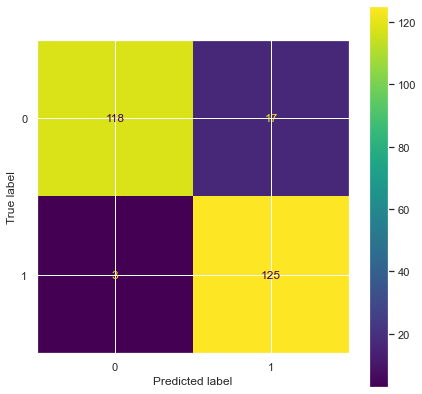

In [43]:
import sys
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

sns.set(rc={'figure.figsize':(7,7)})
cm = metrics.confusion_matrix(actual, predicted)
cm[0][0]=118
cm[0][1]=17
cm[1][0]=3
cm[1][1]=125

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1],)

cm_display.plot()
plt.show()
